### Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_dir = '/content/drive/MyDrive/AIF/'
file_path = 'Dataset_2.0_Akkodis_final.xlsx'
processed_file_path = 'Dataset_2.0_Akkodis_final_processed.xlsx'
best_models_dict = 'best_models.pkl'
best_params_nn_dict = "best_nn_params.pkl"

### Install requirements

In [ ]:
source_path = drive_dir + 'requirements.txt'
!pip install -r {source_path}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.base
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, StratifiedKFold, RandomizedSearchCV, PredefinedSplit
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

from scipy.stats import chi2_contingency

from lime import lime_tabular
import shap

import re
import time
import pickle

from ctgan import CTGAN

random_seed = 42
random_state = 42

###Utils

#####Visualization

In [ ]:
def getPie(df, feature, mapping):
  distribution = df[feature].value_counts(normalize=True)
  plt.figure(figsize=(8, 6))
  labels = [mapping[feature][i] for i in distribution.index]
  plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
  plt.rcParams.update({'font.size': 10})
  plt.title(f'Distribution of {feature}')
  plt.show()

In [ ]:
def plot_category_distributions(df, group_col, target_col, encoding_mappings, reverse_mapping):
    group_values = encoding_mappings[group_col]

    distribs = {}
    for group_key, encoded_value in group_values.items():
        distrib = df[df[group_col] == encoded_value][target_col].value_counts(normalize=True)
        if not distrib.empty:
            distribs[group_key] = distrib

    num_subplots = len(distribs)
    rows = num_subplots // 3 + (num_subplots % 3 > 0)
    cols = min(num_subplots, 3)
    plt.figure(figsize=(num_subplots * 5, num_subplots * 5))
    plt.rcParams.update({'font.size': 4*num_subplots})
    for i, (group_label, distribution) in enumerate(distribs.items()):
        plt.subplot(rows, cols, i + 1)

        labels = [reverse_mapping[target_col][idx] for idx in distribution.index]

        plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f'{target_col} distrib for {group_label} as {group_col.replace("_encoded", "")}')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_bar_norm(data_set, feature, target, encoding_mappings, reverse_mapping):
    plt.rcParams.update({'font.size': 10})
    pivot = data_set.pivot_table(index=feature, columns=target, aggfunc='size', fill_value=0)
    pivot.rename(columns=reverse_mapping[target], inplace=True)
    pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

    ax = pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

    if feature in encoding_mappings.keys():
        ax.set_xticklabels(encoding_mappings[feature].keys())

    plt.title(f'{target} by {feature} (Normalized)')
    plt.ylabel('Proportion')
    plt.xlabel(feature)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


#####shap explanations

In [ ]:
def create_explanations(model, X, name):
    if name.startswith('Neural Network'):
        background_data = shap.sample(X, 10)
        def predict_proba(X):
            # Change here: Cast prediction to float32 before applying sigmoid
            return tf.keras.activations.sigmoid(model.predict(X).astype(np.float32)).numpy()
        explainer = shap.KernelExplainer(predict_proba, background_data)
        shap_values = explainer.shap_values(X.values[:10])
        shap_values = np.squeeze(shap_values)
        print("shap shape:", shap_values.shape)
        return shap_values, X[:10]

    explainer = shap.Explainer(model, X)
    explanations = explainer(X)
    return explanations, X

def summaryPlot(model, X, lf, plot_type, plot_name):
    explanations, X = create_explanations(model, X, plot_name)

    fig, ax = plt.subplots()
    plt.title(f"{plot_name}")
    shap.summary_plot(explanations, X, lf, show=False, plot_size=None, plot_type=plot_type, max_display=len(lf), sort=True)
    plt.tight_layout()
    plt.show()
    plt.close()

#####training

In [ ]:
def reweight_dataset(X_train, y_train, sensitive_features, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    group_counts = X_train.groupby(sensitive_features).size()
    group_weights = 1 / group_counts
    group_weights /= group_weights.sum()

    sample_weights = X_train[sensitive_features].apply(tuple, axis=1).map(group_weights)

    sample_weights /= sample_weights.sum()

    reweighted_indices = np.random.choice(
        X_train.index,
        size=len(X_train),
        replace=True,
        p=sample_weights)
    X_train_reweighted = X_train.loc[reweighted_indices]
    y_train_reweighted = y_train.loc[reweighted_indices]

    return X_train_reweighted, y_train_reweighted


In [ ]:
def fit_predict_model(name, model, X_train, y_train, X_test, y_test, metrics, predictions):
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if name in ['Linear Regression', 'XGBoost']:
        y_proba = y_pred
        y_pred = (y_proba > 0.5).astype(int)
    elif hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred

    predictions[name] = y_pred

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
    recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_proba), 3)

    if sum(y_pred) == 0:
        print(f"Warning: No positive predictions for {name}. Precision and Recall may be ill-defined.")

    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

In [ ]:
def create_model(X_train, neurons=64, optimizer='adam', learning_rate = None, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(len(X_train.columns),)))
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    #neurons = neurons // 2
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    neurons = neurons // 2
    model.add(Dense(neurons, activation=activation,))
    model.add(BatchNormalization())
    model.add(Dense(1))

    if isinstance(optimizer, str):
        if optimizer == 'adam':
            optimizer = Adam
        elif optimizer == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop
        elif optimizer == 'sgd':
            optimizer = tf.keras.optimizers.SGD
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")


    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [ ]:
#new
def fit_nn(name, seed, neural_models, histories, X_train, y_train, X_validation, y_validation, X_test, neural_predictions, best_params, early_stopping=None):

    print(f"Fitting model {name}...")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model = CustomKerasClassifier(input_shape=(X_train.shape[1],), neurons = best_params['neurons'], optimizer = best_params['optimizer'], learning_rate = best_params['learning_rate'], activation = best_params['activation'] )
    neural_models.append(model)

    model.fit(X_train, y_train, validation_data=(X_validation, y_validation), early_stopping=early_stopping)
    history = model.get_history()
    histories.append(history)
    print(f"Model {name} fitted.\n")


In [ ]:
def predict_nn(name, model, X_test, neural_predictions):
    print(f"Predicting with model {name}...")
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    neural_predictions.append(y_pred)
    print(f"Predictions from model {name} stored.\n\n")

In [ ]:
def plot_val_train(h, name):
  metrics = ['loss','accuracy','auc','recall','precision']
  metric_keys = []
  count = 0
  for m in metrics:
    key = re.compile(re.escape(m))
    if any(key.search(k) for k in list(h.keys())):
      count += 1
      keys = [k for k in h.keys() if key.search(k)]
      metric_keys.append(keys)

  if count == 0:
    return

  plt.figure(figsize=(12, 6))

  for i in range(count):
    plt.subplot(1, count, i+1)
    plt.plot(h[metric_keys[i][0]])
    plt.plot(h[metric_keys[i][1]])
    plt.title(f'{name} {metrics[i]}')
    plt.ylabel(metrics[i])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

In [ ]:
def calc_nn_metrics(y_pred, y_test, nn_metrics, name):
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
  recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
  f1 = round(f1_score(y_test, y_pred), 3)
  roc_auc = round(roc_auc_score(y_test, y_pred), 3)

  nn_metrics.append({
      'Model': name,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': f1,
      'ROC AUC': roc_auc
  })

#####fairness metrics

In [ ]:
def calculate_demographic_parity(predictions, y_test, name, significance_level, tolerance, X_test, activate_check=False, model = None):

    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })

    positive_proportions = df.groupby('sensitive_attribute')['predictions'].mean()
    num_class = positive_proportions.shape[0]
    min_proportion = positive_proportions.min()
    max_proportion = positive_proportions.max()
    percentage_difference = (max_proportion - min_proportion)
    discr_gr = reverse_mapping[name][positive_proportions.index[positive_proportions.values.argmin()]]

    if num_class == 2:

        if activate_check == True and percentage_difference > tolerance:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            print(f"{reverse_mapping[name][0]}: {positive_proportions[0]}")
            print(f"{reverse_mapping[name][1]}: {positive_proportions[1]}")
            print(f"Model unfair to: {discr_gr}")
            print("=====================================================================\n\n")
        if percentage_difference <= tolerance:
            return True
        else:
            return discr_gr

    if num_class > 2:
        contingency_table = pd.crosstab(df['predictions'], df['sensitive_attribute'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        if activate_check == True and p <= significance_level:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            if (expected < 5).any():
                print(f"Sparse contigency for {name}")
            else:
              for i in range(len(positive_proportions)):
                print(f"{reverse_mapping[name][i]}: {positive_proportions[i]}")
              print(f"Model unfair to: {discr_gr}")

            print("=====================================================================\n\n")
        if p > significance_level:
            return True
        else:
            return discr_gr

In [ ]:
def calculate_equalized_odds(predictions, true_labels, name, significance_level, tolerance, X_test, activate_check=False, model = None):
    df = pd.DataFrame({
        'predictions': predictions,
        'true_labels': true_labels,
        'sensitive_attribute': X_test[name]
    })

    groups = df['sensitive_attribute'].unique()
    metrics = {}
    for group in groups:
        group_df = df[df['sensitive_attribute'] == group]
        cm = confusion_matrix(group_df['true_labels'], group_df['predictions'], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        if tp + fn == 0:
            print(f"\n\nThere are no positive examples for the group {reverse_mapping[name][group]} in the test set")
        if fp + tn == 0:
            print(f"\n\nThere are no negative examples for the group{reverse_mapping[name]} {group} in the test set")
        tpr = tp / (tp + fn) if tp + fn != 0 else 0
        fpr = fp / (fp + tn) if fp + tn != 0 else 0
        metrics[group] = {'TPR': tpr, 'FPR': fpr}

    tprs = [metrics[group]['TPR'] for group in groups]
    fprs = [metrics[group]['FPR'] for group in groups]

    max_tpr_diff = max(tprs) - min(tprs)
    max_fpr_diff = max(fprs) - min(fprs)

    tpr_within_tolerance = max_tpr_diff <= tolerance*2
    fpr_within_tolerance = max_fpr_diff <= tolerance*2
    result = tpr_within_tolerance and fpr_within_tolerance
    discr_gr_tpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['TPR'])]
    discr_gr_fpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['FPR'])]
    if activate_check == True and result == False:
        max_tpr_group = max(metrics, key=lambda g: metrics[g]['TPR'])
        min_tpr_group = min(metrics, key=lambda g: metrics[g]['TPR'])
        max_fpr_group = max(metrics, key=lambda g: metrics[g]['FPR'])
        min_fpr_group = min(metrics, key=lambda g: metrics[g]['FPR'])
        print("===============================UNFAIR!===============================")
        print(f"Model {model} unfair wrt {name}")
        if tpr_within_tolerance == False:
            print(f"Maximum TPR difference: {max_tpr_diff:.4f} between group {reverse_mapping[name][max_tpr_group]} and group {reverse_mapping[name][min_tpr_group]}")
            print(f"Model unfair to: {discr_gr_tpr}")
        if fpr_within_tolerance == False:
            print(f"Maximum FPR difference: {max_fpr_diff:.4f} between group {reverse_mapping[name][max_fpr_group]} and group {reverse_mapping[name][min_fpr_group]}")
            print(f"Model unfair to: {discr_gr_fpr}")
        print("TPR and FPR for each group:")
        for group, metric in metrics.items():
            print(f"Group {reverse_mapping[name][group]}: TPR={metric['TPR']:.4f}, FPR={metric['FPR']:.4f}")
        print("=====================================================================\n\n")
    if result == False:
      if tpr_within_tolerance == False and fpr_within_tolerance == False:
        if discr_gr_fpr == discr_gr_tpr:
          return discr_gr_fpr
        else:
          return discr_gr_tpr+' '+discr_gr_fpr
      elif tpr_within_tolerance == False:
        return discr_gr_tpr
      else:
        return discr_gr_fpr
    else:
      return True

In [ ]:
def calculate_counterfactual_fairness(predictions, y_test, name, significance_level, tolerance, X_test, model=None, activate_check=False):
    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })

    counterfactual_df = X_test.copy()
    delta = {}
    consistency = {}

    for group in df['sensitive_attribute'].unique():
        counterfactual_df[name] = group

        if isinstance(model, (tf.keras.Sequential, tf.keras.Model)):
            new_preds = model.predict(counterfactual_df, verbose=0)
        else:
            new_preds = model.predict(counterfactual_df)

        if len(np.unique(new_preds)) > 2:
            new_preds = (new_preds > 0.5).astype(int)

        consistency[group] = 1 - np.mean(np.abs(predictions - new_preds))

        n_old = np.sum(predictions)
        n_new = np.sum(new_preds)
        delta[group] = (n_new - n_old) / len(predictions)

    most_inconsistent_group = min(consistency, key=consistency.get)
    counterfactual_consistency = consistency[most_inconsistent_group]

    most_discriminated_group = min(delta, key=delta.get)
    delta_min = delta[most_discriminated_group]
    most_privileged_group = max(delta, key=delta.get)
    delta_max = delta[most_privileged_group]

    is_fair = (delta_max - delta_min < tolerance) and (counterfactual_consistency >= (1 - tolerance))

    if activate_check:
        if not is_fair:
            print("===============================UNFAIR!===============================")
        else:
            print("=====================================================================")
        print(f"Model {model} unfair wrt Counterfactual Fairness on {name}")
        print(f"Counterfactual consistency: {counterfactual_consistency:.4f}")
        print(f"Most inconsistent group: {reverse_mapping[name][most_inconsistent_group]} {delta[most_inconsistent_group]:.4f}")
        print(f"Most discriminated group: {reverse_mapping[name][most_discriminated_group]} {delta_min:.4f}")
        print(f"Most privileged group: {reverse_mapping[name][most_privileged_group]} {delta_max:.4f}")
        print(f"Direction of bias (negative = worse, positive = better)")
        print("=====================================================================\n\n")

    if not is_fair:
        return reverse_mapping[name][most_discriminated_group], delta_min, reverse_mapping[name][most_privileged_group], delta_max

    return True

In [ ]:
def getFairnessTab(fn, models, sensitive_features, predictions, index, X_test, significance_level, tolerance, verbose=False):
    table = []

    for model_name in index:
        temp = []
        for i in range(len(sensitive_features)):
            model_predictions = predictions[model_name]
            output = fn(
                model_predictions,
                y_test,
                sensitive_features[i],
                significance_level,
                tolerance,
                X_test,
                model=models[model_name],
                activate_check=verbose
            )

            if output == True:
                temp.append('')
            else:
                temp.append(output)
        table.append(temp)

    return pd.DataFrame(table, index=index, columns=sensitive_features)


###Classes

In [ ]:
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, neurons=10, activation='relu', optimizer='adam', batch_size=32, epochs=20, learning_rate=0.001):
        self.input_shape = input_shape
        self.neurons = neurons
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        #self._estimator_type = type(KerasClassifier)

    def build_tf_model(self):
        model = Sequential([
            Input(shape=self.input_shape),
            Dense(self.neurons, activation=self.activation),
            BatchNormalization(),
            Dropout(0.4),
            Dense(self.neurons, activation=self.activation),
            BatchNormalization(),
            Dropout(0.4),
            Dense(self.neurons//2, activation=self.activation),
            BatchNormalization(),
            Dense(1)
            #Dense(1, activation='sigmoid')
        ])

        if self.optimizer == 'adam':
            optimizer_fn = Adam
        elif self.optimizer == 'rmsprop':
            optimizer_fn = tf.keras.optimizers.RMSprop
        elif self.optimizer == 'sgd':
            optimizer_fn = tf.keras.optimizers.SGD
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer}")


        model.compile(optimizer=optimizer_fn(learning_rate=self.learning_rate),
                      loss= BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        return model

    def fit(self, X, y, validation_data=None, early_stopping=None):
        self.classes_ = np.unique(y)
        self.class_weights = {0: 1, 1: len(y[y == 0]) / len(y[y == 1])}
        self.model = self.build_tf_model()
        if validation_data is not None:
          X_val, y_val = validation_data
          self.history = self.model.fit(X, y, epochs=self.epochs,
                         batch_size=self.batch_size, verbose=1,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping],
                         class_weight=self.class_weights)
        else:
          self.model.fit(X, y, epochs=self.epochs,
                         batch_size=self.batch_size, verbose=1,
                         class_weight=self.class_weights)
          self.history = None
        return self

    def predict(self, X):
        y_pred_proba = self.model.predict(X)
        return (y_pred_proba > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        y_pred_proba = self.model.predict(X)
        y_pred_proba = sigmoid(y_pred_proba)
        y_pred_proba = y_pred_proba.numpy()
        y_pred_proba = y_pred_proba.reshape(-1, 1)
        return np.hstack([1 - y_pred_proba, y_pred_proba])


    def score(self, X, y):
        y_pred_proba = self.predict_proba(X)[:, 1]
        return roc_auc_score(y, y_pred_proba)

    def get_params(self, deep=True):
        return {'input_shape': self.input_shape,
                'neurons': self.neurons,
                'activation': self.activation,
                'optimizer': self.optimizer,
                'batch_size': self.batch_size,
                'epochs': self.epochs,
                'learning_rate': self.learning_rate}

    def get_history(self):
        return self.history


## Dataset Import

In [ ]:
df = pd.read_excel(drive_dir + file_path)

print(f"There are {df['Id'].unique().shape[0]} candidates\n")

print(f"Total number of rows: {df.shape[0]}\n")

print(f"HIRED distribution: \n\n{df.groupby('Id')['Hired'].first().value_counts()}\n\n")

df.head()

There are 2973 candidates

Total number of rows: 8424

HIRED distribution: 

Hired
0    2478
1     495
Name: count, dtype: int64




Id Candidate State      Age Range     Sex Protected Category  \
0    4           hired  26 - 30 years    male                 no   
1   62           hired  26 - 30 years    male                 no   
2   98           hired  26 - 30 years    male                 no   
3  152           hired     > 45 years  female                yes   
4  165           hired  26 - 30 years    male                 no   

                                                 Tag  \
0  catia (harness, part design, sheet metal), cat...   
1         c#, c, c#, vectorcast, testing, vectorcast   
2  autocad, gt power, hypermesh, mechanical engin...   
3                                      not specified   
4                               angular, javascript.   

                                        Study Area  \
0  aeronautical/aerospace/astronautics engineering   
1                           electronic engineering   
2                           mechanical engineering   
3                                            other   
4                                      informatics   

                  Study Title Years Experience   Sector  ...  \
0  professional qualification            [3-5]  railway  ...   
1           three-year degree            [1-3]  railway  ...   
2           three-year degree              [0]   others  ...   
3       middle school diploma            [+10]   others  ...   
4           three-year degree            [1-3]  telecom  ...   

              Residence_coord            Assumption_coord Distance (km)  \
0  (40.90689555, 14.39335586)  (45.54749699, 11.54597109)    564.975442   
1   (40.79461702, 16.7525404)  (41.12559562, 16.86737016)     38.006184   
2    (45.0732745, 7.68068748)    (45.0732745, 7.68068748)      0.000000   
3    (45.0732745, 7.68068748)    (45.0732745, 7.68068748)      0.000000   
4  (43.83219044, 11.19842773)    (44.4943668, 11.3417208)     74.465310   

                                       Position_Info Similarity_Score  \
0  wiring harness architecture engineer engineeri...             0.09   
1  vv tc engineer tech consulting solutions advan...             0.06   
2  powertrain calibration engineer engineering ju...             0.11   
3  internship cleaning cat prot enabling function...             0.00   
4  frontend developer tech consulting solutions c...             0.18   

  Similarity_Score_Study_Area Study_Title_Score Similarity_Score_Last_Role  \
0                        0.07             -0.29                        0.0   
1                        1.00              0.00                        0.0   
2                        0.16             -0.14                        0.0   
3                        0.00              0.00                        0.0   
4                        1.00              0.00                        0.0   

  Years_Exp_Score Ral_Score  
0            0.17      0.00  
1            0.00     -0.07  
2           -0.03      0.00  
3            1.00      0.00  
4            0.00     -0.07  

[5 rows x 55 columns]

##Data Set
Some columns will be dropped either because they would not be available (i.e. Candidate State) or because of redundancy.

In [ ]:
data_set = df.copy()

columns_to_drop = ['Candidate State', 'Tag' , 'Recruitment Request', 'Last Role',
                   'Job Description', 'Candidate Profile', 'Year Of Insertion', 'Year Of Recruitment',
                   'Job Title Hiring', 'Years Experience.1', 'Study Level', 'Study Area.1',
                   'Job ID', 'Residence_coord', 'Assumption_coord', 'Assumption Headquarters', 'Residence Italian City',
                   'Candidate_Info', 'Position_Info', 'Akkodis Headquarters', 'Job Family Hiring', 'Linked_Search__Key']

data_set = data_set.drop(columns=columns_to_drop)

for col in data_set.columns:
  print(f"{col}: \n {data_set[col].unique()}")

Id: 
 [    4    62    98 ... 81622 81623 81630]
Age Range: 
 ['26 - 30 years' '> 45 years' '< 20 years' '36 - 40 years' '20 - 25 years'
 '31 - 35 years' '40 - 45 years']
Sex: 
 ['male' 'female']
Protected Category: 
 ['no' 'yes']
Study Area: 
 ['aeronautical/aerospace/astronautics engineering'
 'electronic engineering' 'mechanical engineering' 'other' 'informatics'
 'computer engineering' 'biomedical engineering' 'industrial engineering'
 'chemical engineering' 'economic - statistics' 'surveyor'
 'automotive engineering' 'automation/mechatronics engineering'
 'chemist - pharmaceutical' 'other humanities subjects'
 'other scientific subjects' 'political-social' 'management engineering'
 'electrical engineering' 'telecommunications engineering'
 'energy and nuclear engineering' 'psychology' 'information engineering'
 'accounting' 'communication sciences' 'mathematics' 'literary'
 'civil/civil and environmental engineering'
 'humanistic high school diploma' 'linguistics'
 'agriculture and

##Preprocessing
### Categorical - Numerical mapping

In [ ]:
ral_mapping = {
     '-20k': 10,
     '20-22k': 21,
     '22-24k': 23,
     '24-26k': 25,
     '26-28k': 27,
     '28-30k': 29,
     '30-32k': 31,
     '32-34k': 33,
     '34-36k': 35,
     '36-38k': 37,
     '38-40k': 39,
     '40-42k': 41,
     '42-44k': 43,
     '44-46k': 45,
     '46-48k': 47,
     '48-50k': 49,
     '+50k': 70,
     'not specified': 'not specified'
}

for col in data_set.columns:
  if 'Ral' in col and col != 'Ral_Score':
     data_set[col] = data_set[col].map(ral_mapping)

years_exp_mapping = {
    '[0]': 0,
    '[0-1]': 0.5,
    '[1-3]': 2,
    '[3-5]': 4,
    '[5-7]': 6,
    '[7-10]': 8.5,
    '[+10]': 20
}

data_set['Years Experience'] = data_set['Years Experience'].map(years_exp_mapping)

### Encoding of categorical columns

In [ ]:
categorical_columns = ['Sex', 'Age Range', 'Protected Category', 'Study Area', 'Study Title',
                       'Sector', 'Residence Country', 'Residence Italian Region', 'Residence Italian Province',
                       'European Residence', 'Italian Residence']
numerical_columns = [col for col in data_set.columns if col not in categorical_columns]

In [ ]:
encoding_mappings = {}

encoding_mappings['Age Range_encoded'] = {
    '< 20 years': 0,
    '20 - 25 years': 1,
    '26 - 30 years': 2,
    '31 - 35 years': 3,
    '36 - 40 years': 4,
    '40 - 45 years': 5,
    '> 45 years': 6
}

data_set['Age Range_encoded'] = data_set['Age Range'].map(encoding_mappings['Age Range_encoded'])
data_set = data_set.drop(columns='Age Range')

categorical_columns.remove('Age Range')

encoding_mappings['Study Title_encoded'] = {
    'middle school diploma': 0,
    'professional qualification': 1,
    'high school graduation': 2,
    'three-year degree': 3,
    'five-year degree': 4,
    'master\'s degree': 5,
    'doctorate': 6
}

data_set['Study Title_encoded'] = data_set['Study Title'].map(encoding_mappings['Study Title_encoded'])
data_set = data_set.drop(columns='Study Title')

categorical_columns.remove('Study Title')

for col in categorical_columns:
  label_encoder = LabelEncoder()
  data_set[f"{col}_encoded"] = label_encoder.fit_transform(data_set[col])
  encoding_mappings[f"{col}_encoded"] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data_set = data_set.drop(columns=categorical_columns)

encoding_mappings['Hired'] = {'Not Hired': 0, 'Hired': 1}

reverse_mapping = {}

for col, mapping in encoding_mappings.items():
    reverse_mapping[col] = {v: k for k, v in mapping.items()}

###NaN handling

'not specified' values for numerical columns are replaced with the mean value.

In [ ]:
not_spec_col = []

for col in data_set.columns:
  if 'not specified' in data_set[col].unique() :
    not_spec_col.append(col)

for col in not_spec_col:
  if col in numerical_columns:
    data_set[col] = pd.to_numeric(data_set[col], errors='coerce')
    mean_val = data_set[col].dropna().mean()
    if pd.isna(mean_val):
      mean_val = 0
    else:
      mean_val = round(mean_val)

    data_set[col] = data_set[col].replace('not specified', mean_val)
    data_set[col] = data_set[col].fillna(mean_val)

for col in not_spec_col:
  print(type(data_set[col][0]))
  print(f"{col}: {data_set[col].unique()}")

<class 'numpy.float64'>
Overall: [3. 2. 4. 1.]
<class 'numpy.float64'>
Minimum Ral: [25. 29. 23. 21. 10. 31. 27. 37. 33. 39. 41. 35. 70.]
<class 'numpy.float64'>
Ral Maximum: [35. 31. 25. 30. 29. 27. 21. 10. 33. 37. 49. 41. 45. 39. 43. 70. 23.]
<class 'numpy.float64'>
Current Ral: [29. 23. 33. 35. 10. 27. 31. 25. 21. 70. 39. 43. 37. 41. 45. 49. 47.]
<class 'numpy.float64'>
Expected Ral: [36. 33. 27. 41. 21. 29. 23. 31. 37. 25. 70. 39. 35. 43. 10. 45. 47. 49.]
<class 'numpy.float64'>
Technical Skills: [3. 2. 1. 4.]
<class 'numpy.float64'>
Standing/Position: [2. 3. 4. 1.]
<class 'numpy.float64'>
Communication: [2. 3. 4. 1.]
<class 'numpy.float64'>
Maturity: [2. 3. 4. 1.]
<class 'numpy.float64'>
Dynamism: [3. 2. 4. 1.]
<class 'numpy.float64'>
Mobility: [3. 2. 1. 4.]
<class 'numpy.float64'>
English: [3. 4. 2. 1.]


### Standardization

In [ ]:
for col in numerical_columns:
  print(f"{col}: {np.sort(data_set[col].unique().tolist())}")

Id: [    4     8    24 ... 81622 81623 81630]
Years Experience: [ 0.   0.5  2.   4.   6.   8.5 20. ]
Overall: [1. 2. 3. 4.]
Minimum Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 70.]
Ral Maximum: [10. 21. 23. 25. 27. 29. 30. 31. 33. 35. 37. 39. 41. 43. 45. 49. 70.]
Current Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49. 70.]
Expected Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 36. 37. 39. 41. 43. 45. 47. 49. 70.]
Technical Skills: [1. 2. 3. 4.]
Standing/Position: [1. 2. 3. 4.]
Communication: [1. 2. 3. 4.]
Maturity: [1. 2. 3. 4.]
Dynamism: [1. 2. 3. 4.]
Mobility: [1. 2. 3. 4.]
English: [1. 2. 3. 4.]
Hired: [0 1]
Distance (km): [0.00000000e+00 5.58543808e+00 6.26429597e+00 ... 1.06825131e+04
 1.20911732e+04 1.21102667e+04]
Similarity_Score: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.33 0.34 0.35 0.37 0.38 0.39 0.4  0.42 0.46 0.5  0.54
 0.55 0.6 

###Std Scaler

In [ ]:
columns_to_standardize = ['Years Experience', 'Minimum Ral', 'Ral Maximum', 'Current Ral',
                          'Expected Ral', 'Distance (km)']

scaler = StandardScaler()

for col in columns_to_standardize:
  data_set[f"{col}_not_std"] = data_set[col]

data_set[columns_to_standardize] = scaler.fit_transform(data_set[columns_to_standardize])

std_mappings = {}
for col in columns_to_standardize:
    std_mappings[col] = {
        row[f"{col}_not_std"]: round(row[col], 2) for _, row in data_set.iterrows()
    }

for col in columns_to_standardize:
  data_set = data_set.drop(columns=f"{col}_not_std")

data_set[columns_to_standardize] = round(data_set[columns_to_standardize], 2)

reverse_std_mappings = {}

for col, mapping in std_mappings.items():
    reverse_std_mappings[col] = {v: k for k, v in mapping.items()}

##Export

In [ ]:
data_set.to_excel(drive_dir+processed_file_path, index=False)

In [ ]:
data_set = pd.read_excel(drive_dir+processed_file_path)

## Correlation matrix

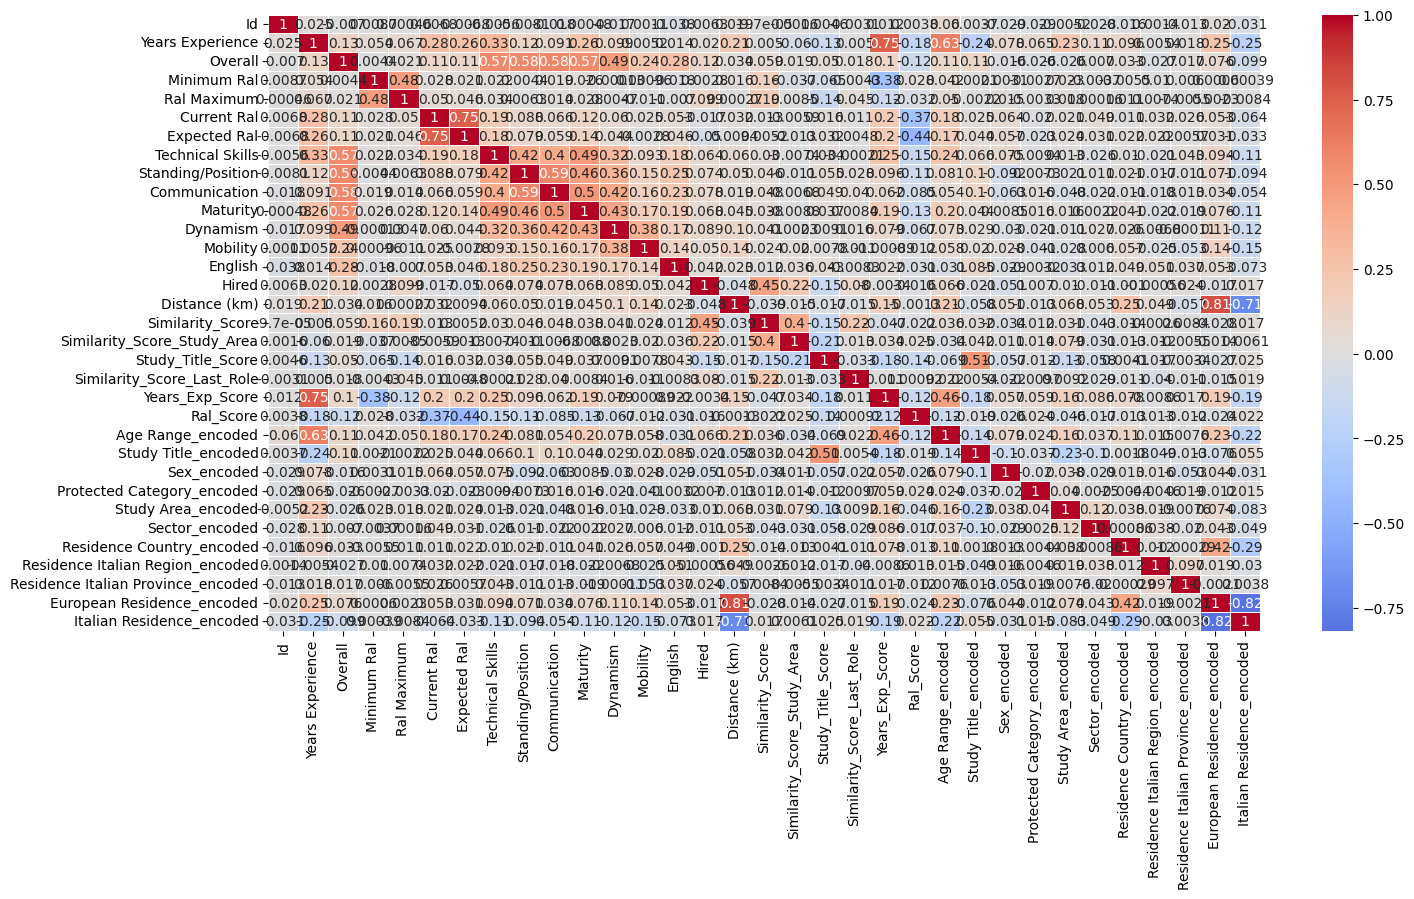

In [ ]:
# Correlation matrix
corr_matrix = data_set.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.show()

##Data Analysis

###Custom orders

###Hired

In [ ]:
data_set['Hired'].value_counts()

Hired
0    7929
1     495
Name: count, dtype: int64

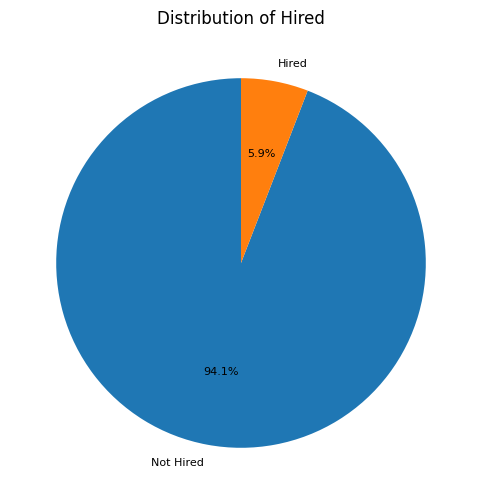

In [ ]:
getPie(data_set, 'Hired', reverse_mapping)

###Sex

In [ ]:
data_set['Sex_encoded'].value_counts()

Sex_encoded
1    6776
0    1648
Name: count, dtype: int64

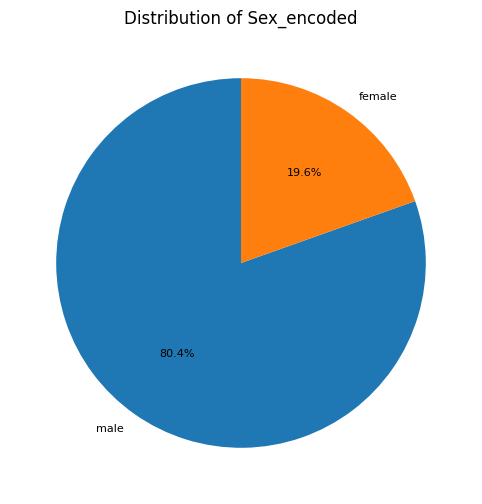

In [ ]:
getPie(data_set, 'Sex_encoded', reverse_mapping)

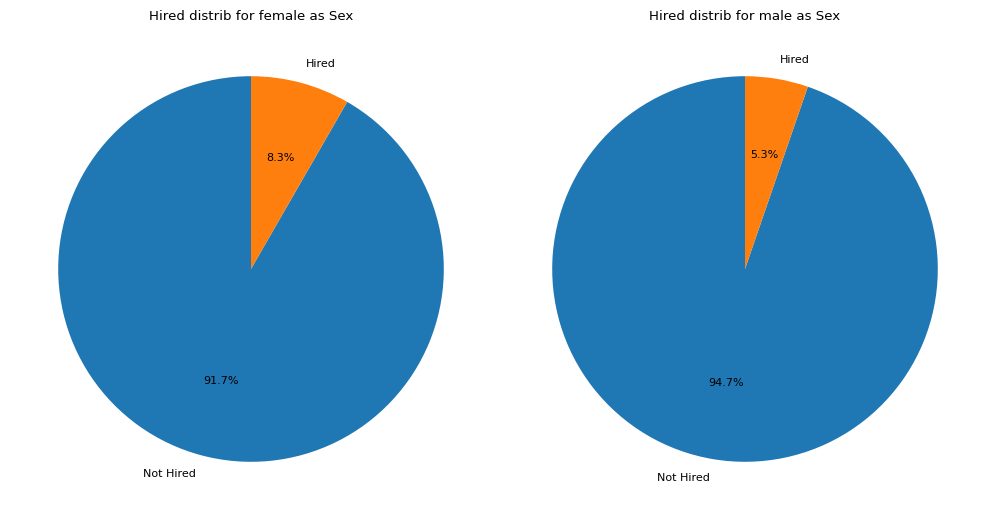

In [ ]:
plot_category_distributions(data_set, 'Sex_encoded', 'Hired', encoding_mappings, reverse_mapping)

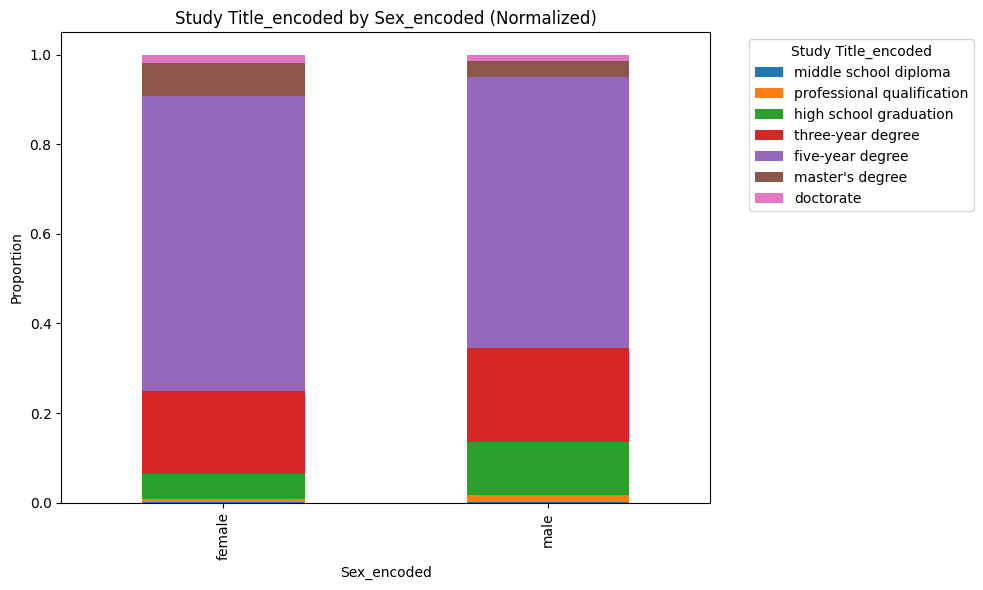

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

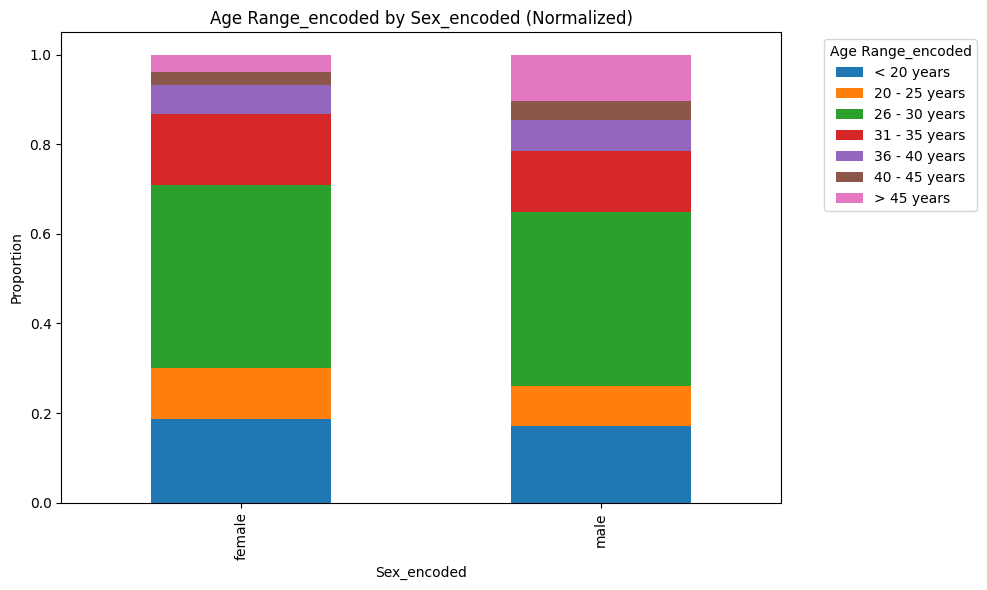

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Age Range_encoded', encoding_mappings, reverse_mapping)

In [ ]:
years_exp_rev_mapping = {
    v: k for k, v in years_exp_mapping.items()
}

In [ ]:
for k, v in reverse_std_mappings['Years Experience'].items():
  reverse_std_mappings['Years Experience'][k] = years_exp_rev_mapping[v]

In [ ]:
reverse_std_mappings['Sex_encoded'] = {}
reverse_std_mappings['Sex_encoded'][0] = 'female'
reverse_std_mappings['Sex_encoded'][1] = 'male'

std_mappings['Sex_encoded'] = {}
std_mappings['Sex_encoded']['female'] = 0
std_mappings['Sex_encoded']['male'] = 1

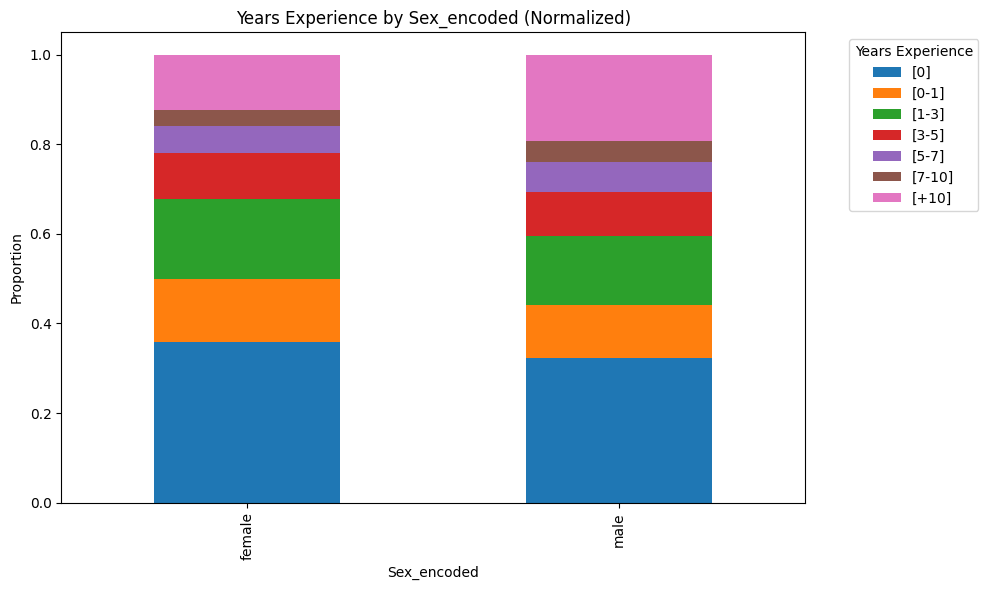

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

###Age Range

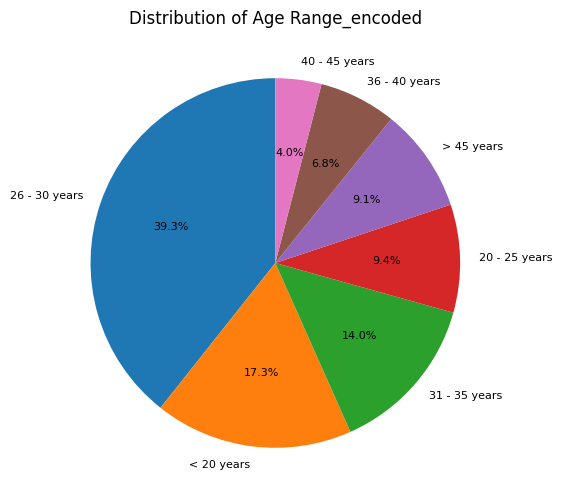

In [ ]:
getPie(data_set, 'Age Range_encoded', reverse_mapping)

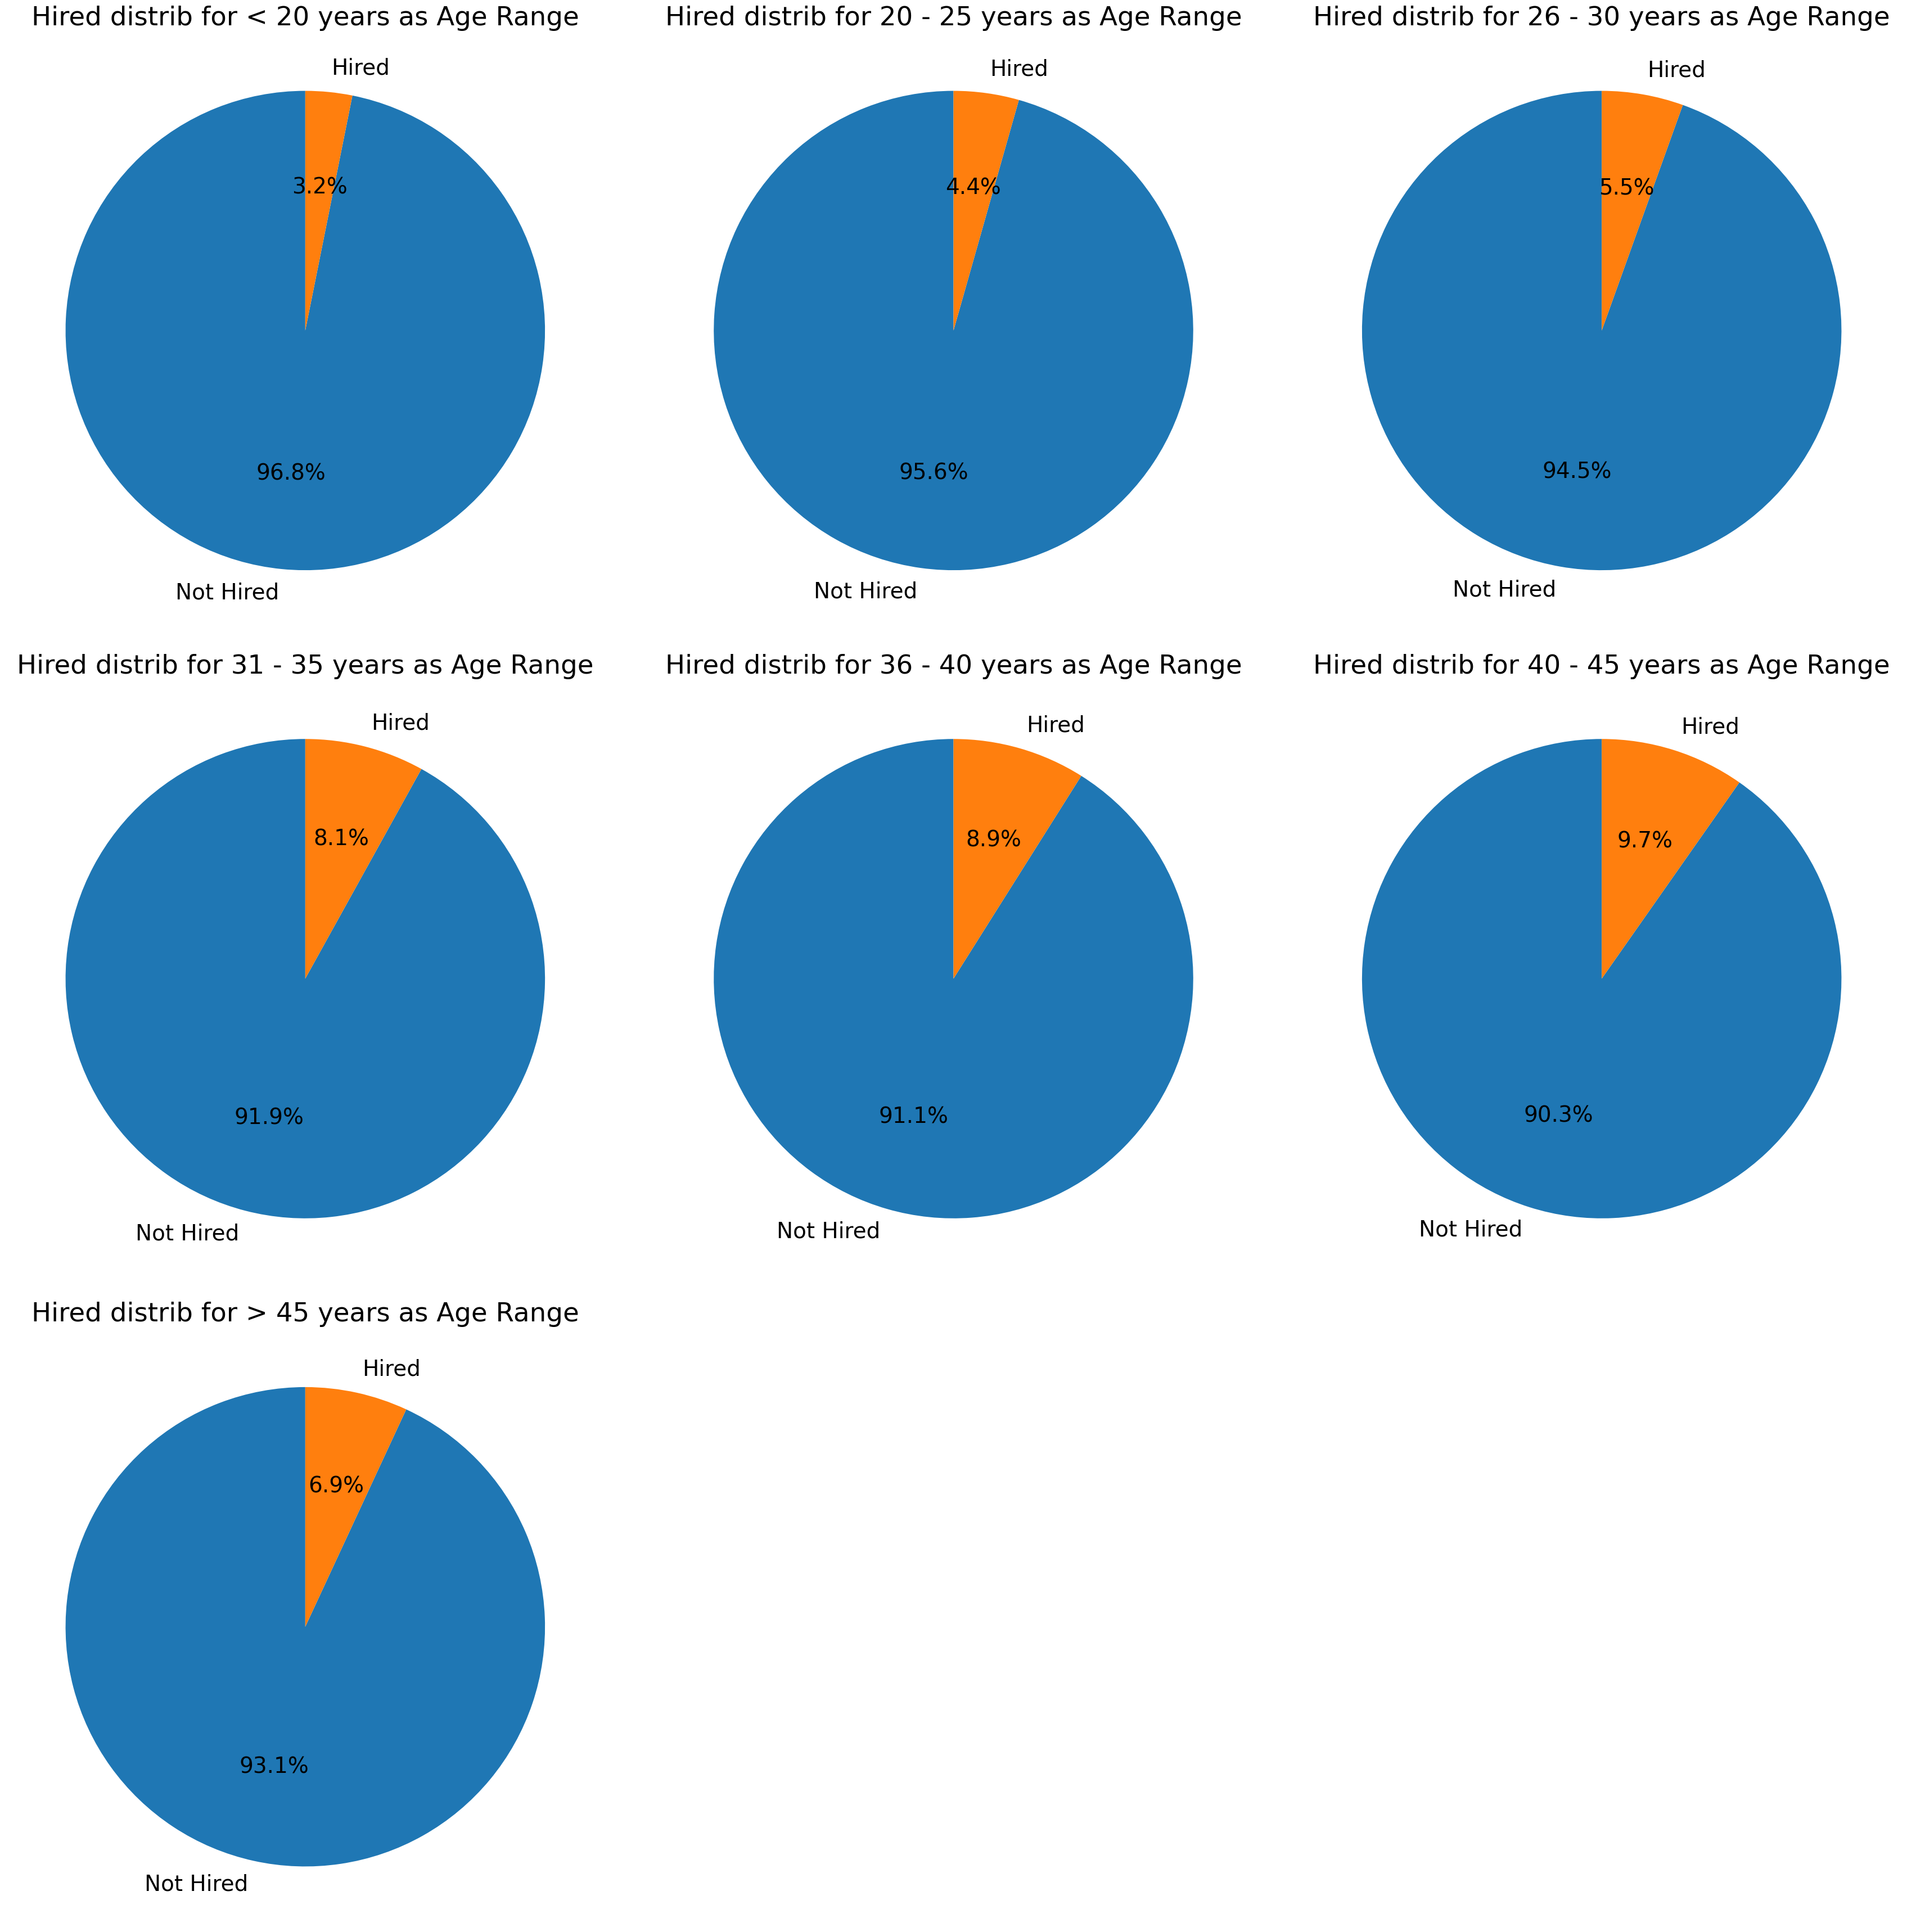

In [ ]:
plot_category_distributions(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

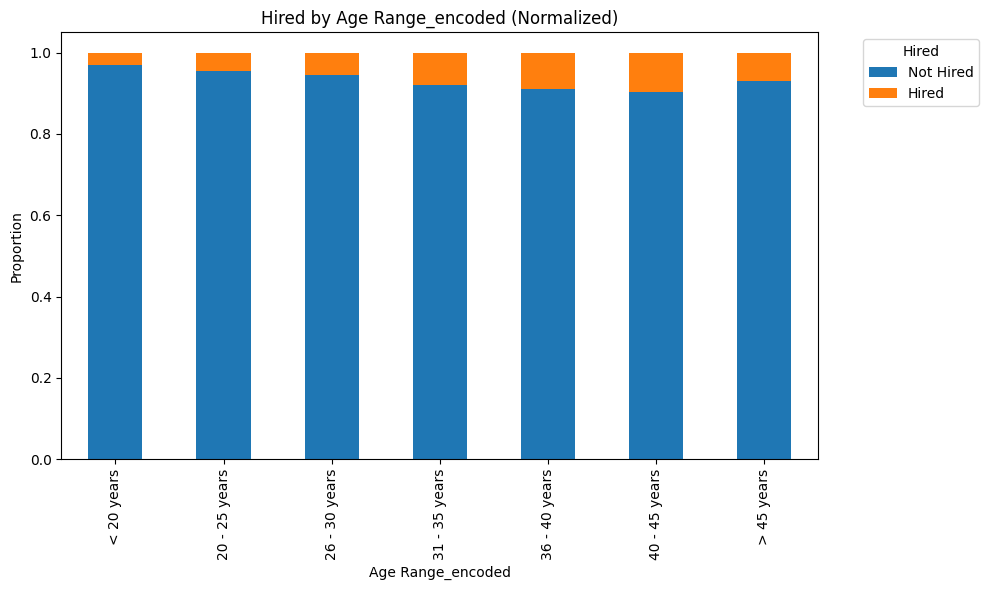

In [ ]:
plot_bar_norm(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

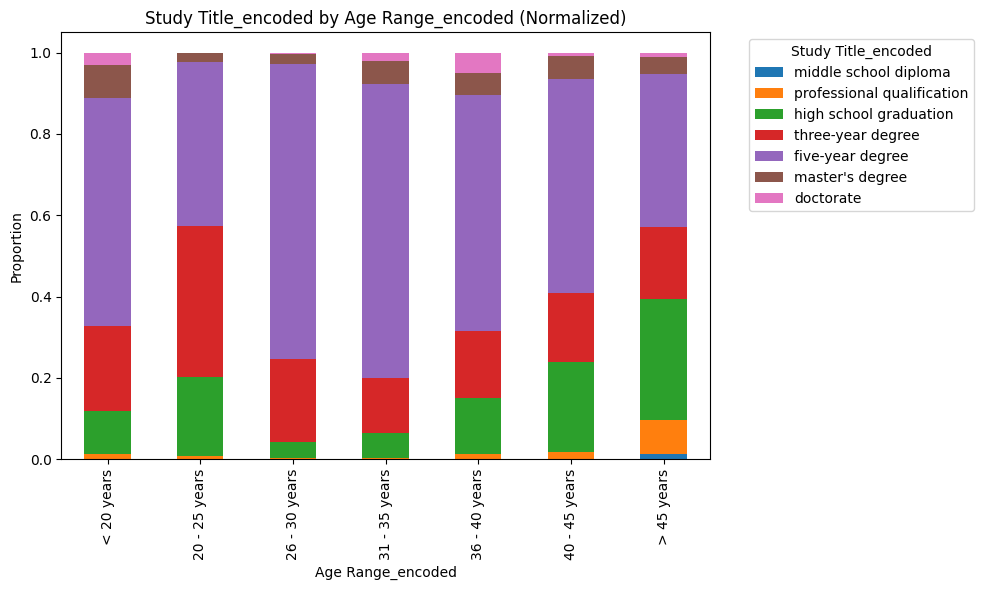

In [ ]:
plot_bar_norm(data_set, 'Age Range_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

###Protected Category

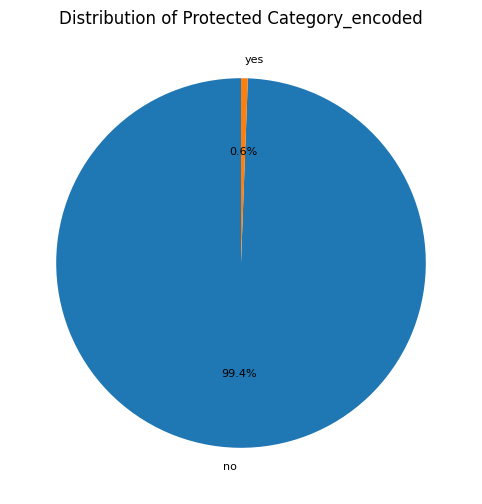

In [ ]:
getPie(data_set, 'Protected Category_encoded', reverse_mapping)

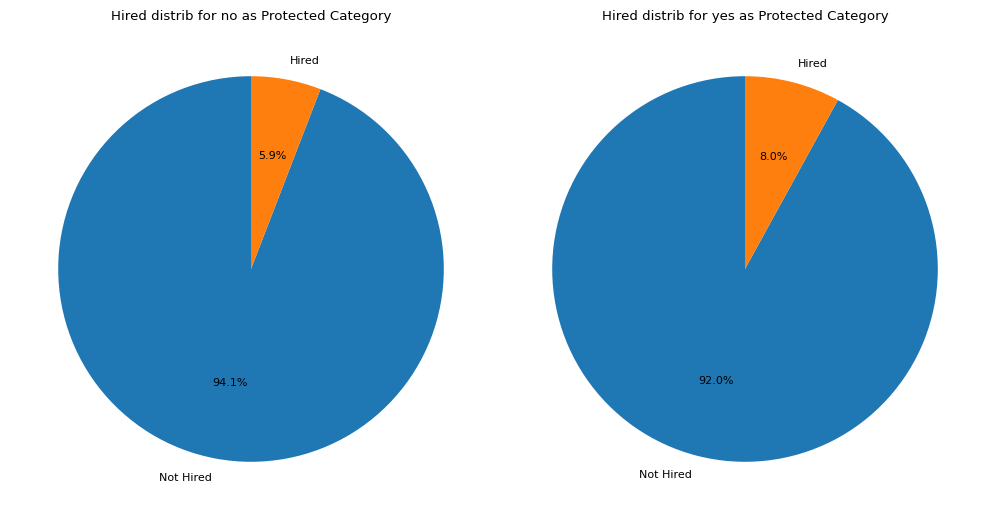

In [ ]:
plot_category_distributions(data_set, 'Protected Category_encoded', 'Hired', encoding_mappings, reverse_mapping)

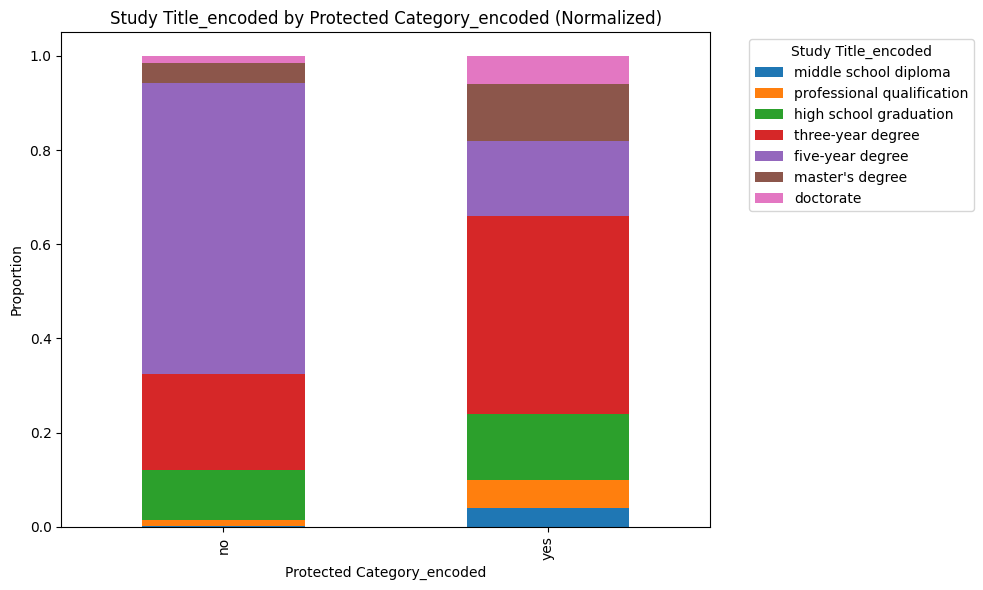

In [ ]:
plot_bar_norm(data_set, 'Protected Category_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

In [ ]:
std_mappings['Protected Category_encoded'] = encoding_mappings['Protected Category_encoded']
reverse_std_mappings['Protected Category_encoded'] = reverse_mapping['Protected Category_encoded']

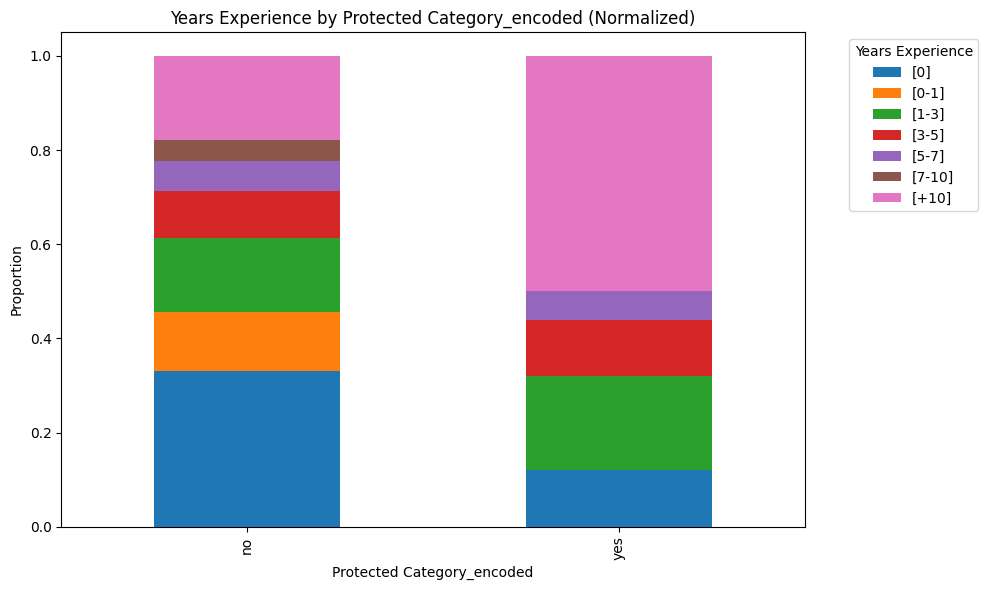

In [ ]:
plot_bar_norm(data_set, 'Protected Category_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

###Italian

In [ ]:
data_set['Italian Residence_encoded'].value_counts()

Italian Residence_encoded
1    8115
0     309
Name: count, dtype: int64

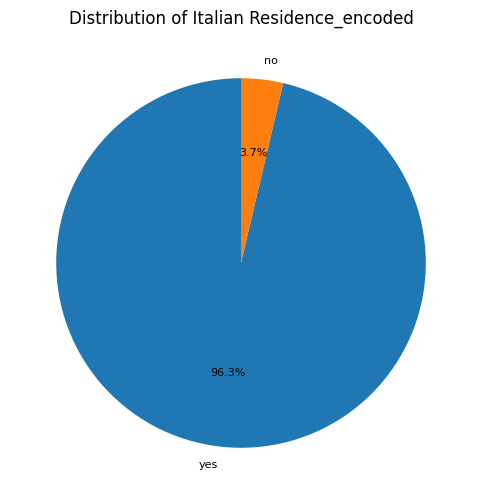

In [ ]:
getPie(data_set, 'Italian Residence_encoded', reverse_mapping)

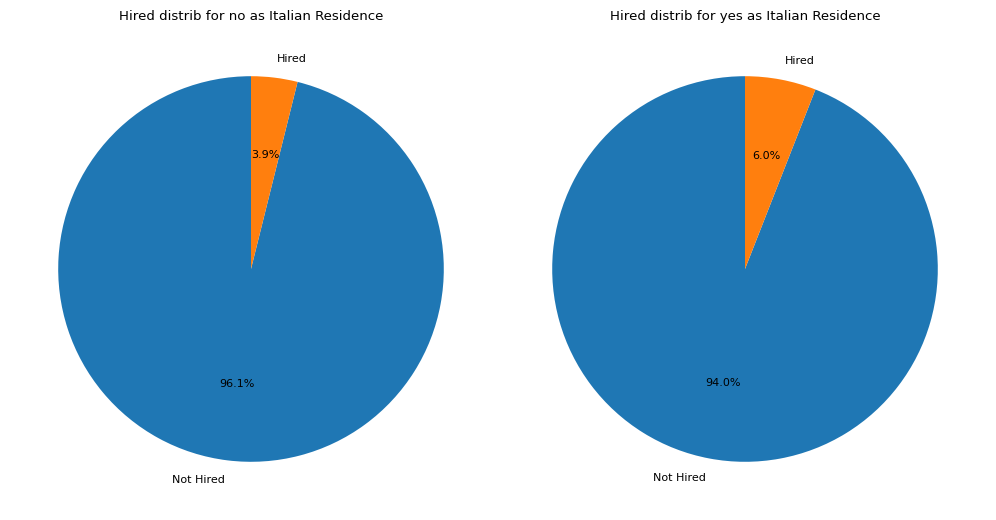

In [ ]:
plot_category_distributions(data_set, 'Italian Residence_encoded', 'Hired', encoding_mappings, reverse_mapping)

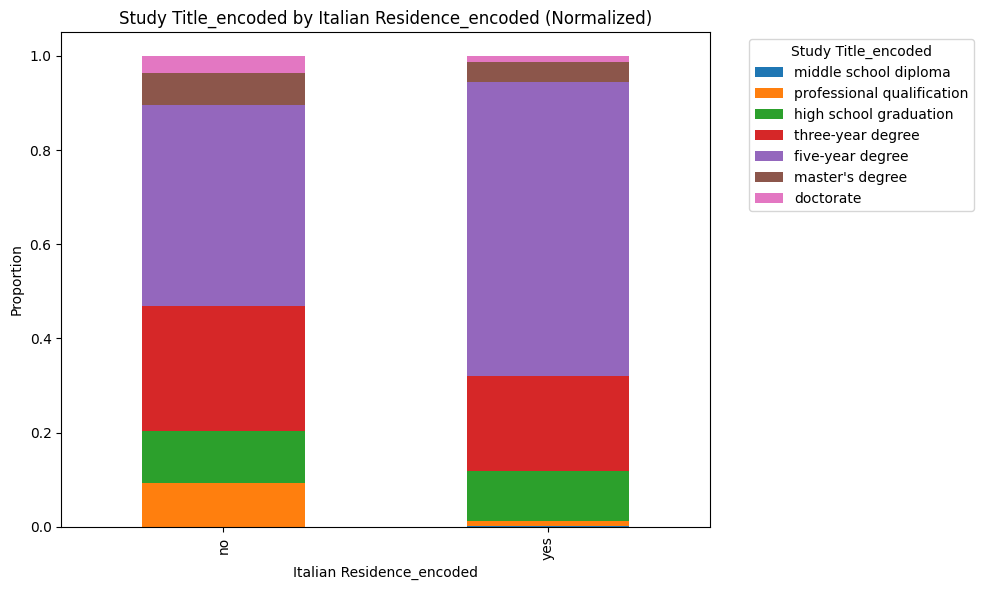

In [ ]:
plot_bar_norm(data_set, 'Italian Residence_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

In [ ]:
std_mappings['Italian Residence_encoded'] = encoding_mappings['Italian Residence_encoded']
reverse_std_mappings['Italian Residence_encoded'] = reverse_mapping['Italian Residence_encoded']

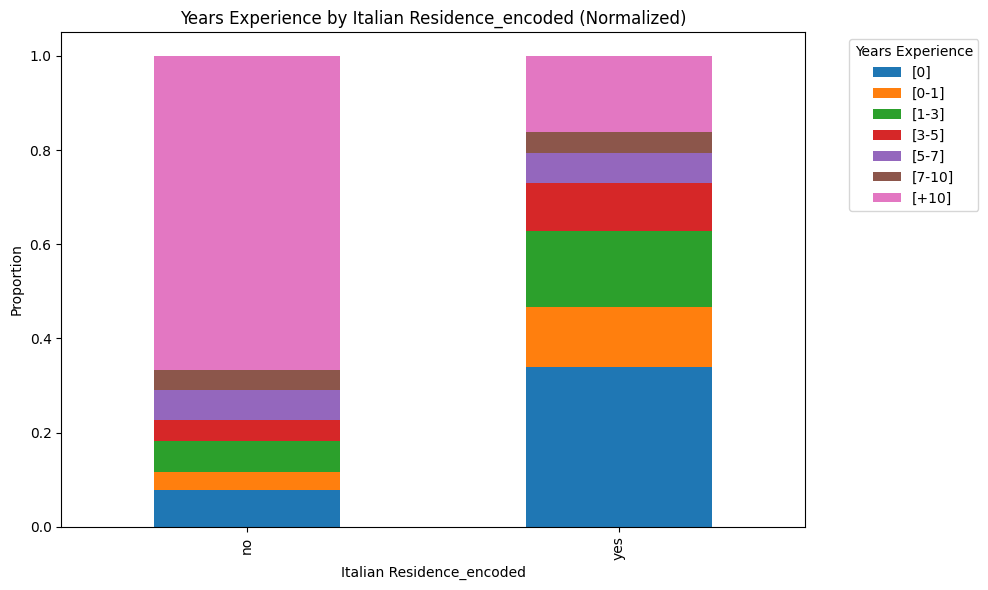

In [ ]:
plot_bar_norm(data_set, 'Italian Residence_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

##GRIDSEARCH

###Train Val Test split

In [ ]:
data_set = shuffle(data_set, random_state=random_state)
train_val_set, test_set = train_test_split(data_set, test_size=0.25, stratify=data_set[['Hired', 'Protected Category_encoded']], random_state=random_state)


In [ ]:
ctgan = CTGAN(verbose=True)

minority_class = train_val_set[train_val_set['Hired'] == 1]
categorical_features = [f"{col}_encoded" for col in categorical_columns]

ctgan.fit(minority_class, categorical_features, epochs=300)


Gen. (-0.58) | Discrim. (-0.15): 100%|██████████| 300/300 [01:05<00:00,  4.57it/s]


In [ ]:
n = train_val_set[train_val_set['Hired'] == 0].shape[0]
samples = ctgan.sample(n)

for col in categorical_features:
    samples = samples[samples[col].isin(train_val_set[col].unique())]
print(f"{n - len(samples)} samples removed")

samples['Id'] = samples['Id'].apply(lambda x: x if x < 0 else -x)

0 samples removed


In [ ]:
balanced_train_set = pd.concat([samples, train_val_set], ignore_index=True)
balanced_train_set = shuffle(balanced_train_set, random_state=random_state)

X_train = balanced_train_set.drop(columns=['Hired', 'Id'])
#X_train = train_val_set.drop(columns=['Hired', 'Id'])
y_train = balanced_train_set['Hired']
#y_train = train_val_set['Hired']
X_test = test_set.drop(columns=['Hired', 'Id'])
y_test = test_set['Hired']
balanced_train_set = pd.concat([samples, train_val_set], ignore_index=True)
balanced_train_set = shuffle(balanced_train_set, random_state=random_state)

X_train = balanced_train_set.drop(columns=['Hired', 'Id'])
#X_train = train_val_set.drop(columns=['Hired', 'Id'])
y_train = balanced_train_set['Hired']
#y_train = train_val_set['Hired']
X_test = test_set.drop(columns=['Hired', 'Id'])
y_test = test_set['Hired']

#cross val
valid_indices = [i for i in balanced_train_set.index if i in train_val_set.index]
#split_index = [-1 if i not in train_val_set.index else 0 for i in balanced_train_set.index]
#split_index = [0 for i in train_val_set.index]
#cv = PredefinedSplit(test_fold=split_index)
#cv = PredefinedSplit(test_fold=split_index)

###Models

In [ ]:
model_list = ['dt' # decision tree
             ,'lr' #Linear Regression
             ,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             ,'lp'   # linear perceptron
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             ]

model_params = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{
                      'n_neighbors': list(range(1,10)),
                      #'leaf_size': (20,40,1),
                      #'p': (1,2),
                      'weights': ('uniform', 'distance'),
                      'metric': ['euclidean', 'manhattan'],
                      }]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,20,4)],
                      'n_estimators':[*range(10,30,5)],
                      'class_weight': [None,'balanced']
                      }]
          },
    'lr': {'name': 'Linear Regression   ',
           'estimator': LinearRegression(),
           'param': [{
               'fit_intercept': [True, False],
               'positive': [True,False]}]
          }

}

In [ ]:
scorings = ['accuracy',
            'precision_macro',
            'recall_macro',
            'f1_macro',
            ]

In [ ]:
from sklearn.model_selection import ParameterGrid
trials = {m: len(list(ParameterGrid(model_params[m]['param']))) for m in model_list}
trials

{'dt': 38, 'lr': 4, 'nb': 9, 'rf': 32, 'lp': 4, 'knn': 36, 'adb': 20}

In [ ]:
n_splits = 3
train_splits = []
val_splits = []

for _ in range(n_splits):
  val_size = int(0.2*len(valid_indices))
  val_fold = np.random.choice(valid_indices, val_size, replace=False)
  val_fold = val_fold.tolist()

  train_fold = [i for i in X_train.index if i not in val_fold]
  train_splits.append(train_fold)
  val_splits.append(val_fold)

In [ ]:
def binarized_f1(y_true, y_pred):
    return f1_score(y_true, (y_pred > 0.5).astype(int))

results = []
clfs = {}
predictions = {}

for scoring in scorings:
    print(f"\n\nGridsearch with scoring {scoring}:\n")
    clfs[scoring] = []
    for m in model_list:
        print(f"Training model: {model_params[m]['name']}")
        if m == 'lr':
          clf = GridSearchCV(
              model_params[m]['estimator'],
              model_params[m]['param'],
              cv=list(zip(train_splits, val_splits)),
              scoring=make_scorer(binarized_f1),
              n_jobs=-1
          )
        else:
          clf = GridSearchCV(
              model_params[m]['estimator'],
              model_params[m]['param'],
              cv=list(zip(train_splits, val_splits)),
              scoring=scoring,
              n_jobs=-1
          )

        clf.fit(X_train, y_train)
        y_true, y_pred = y_test, clf.predict(X_test)

        if m == 'lr':
            y_pred = (y_pred > 0.5).astype(int)
        if m not in predictions:
            predictions[m] = {}
        predictions[m][scoring] = y_pred

        cr = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        results.append({
            'scoring': scoring,
            'model': model_params[m]['name'],
            'best_params': clf.best_params_,
            'accuracy': cr['accuracy'],
            'precision': cr['macro avg']['precision'],
            'recall': cr['macro avg']['recall'],
            'f1_score': cr['macro avg']['f1-score']
        })

        clfs[scoring].append(clf)

results_df = pd.DataFrame(results)




Gridsearch with scoring accuracy:

Training model: Decision Tree       
Training model: Linear Regression   
Training model: Gaussian Naive Bayes
Training model: Random forest       
Training model: Linear Perceptron   
Training model: K Nearest Neighbor 
Training model: AdaBoost           


Gridsearch with scoring precision_macro:

Training model: Decision Tree       
Training model: Linear Regression   
Training model: Gaussian Naive Bayes
Training model: Random forest       
Training model: Linear Perceptron   
Training model: K Nearest Neighbor 
Training model: AdaBoost           


Gridsearch with scoring recall_macro:

Training model: Decision Tree       
Training model: Linear Regression   
Training model: Gaussian Naive Bayes
Training model: Random forest       
Training model: Linear Perceptron   
Training model: K Nearest Neighbor 
Training model: AdaBoost           


Gridsearch with scoring f1_macro:

Training model: Decision Tree       
Training model: Linear Regression

In [ ]:
for score in scorings:
    scoring_filter = score
    display(results_df[results_df.scoring==scoring_filter]\
                .sort_values(by='f1_score',ascending=False)\
                .drop('scoring',axis=1)\
                .style.format(precision=3)\
                .set_caption('\n\nResults for scoring "{}"'.format(scoring_filter)))

In [ ]:
best_model_params = {}

for scoring in scorings:
  best_model_params[scoring] = {}
  for m in model_list:
      best_model_params[scoring][m] = {
          'name': model_params[m]['name'],
          'estimator': clfs[scoring][model_list.index(m)].best_estimator_
      }

In [ ]:
best_model_params

{'accuracy': {'dt': {'name': 'Decision Tree       ',
   'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42)},
  'lr': {'name': 'Linear Regression   ', 'estimator': LinearRegression()},
  'nb': {'name': 'Gaussian Naive Bayes', 'estimator': GaussianNB()},
  'rf': {'name': 'Random forest       ',
   'estimator': RandomForestClassifier(class_weight='balanced', max_depth=16, n_estimators=25,
                          random_state=42)},
  'lp': {'name': 'Linear Perceptron   ',
   'estimator': Perceptron(class_weight='balanced', random_state=42)},
  'knn': {'name': 'K Nearest Neighbor ',
   'estimator': KNeighborsClassifier(metric='euclidean', n_neighbors=1)},
  'adb': {'name': 'AdaBoost           ',
   'estimator': AdaBoostClassifier(learning_rate=1.5, n_estimators=40, random_state=42)}},
 'precision_macro': {'dt': {'name': 'Decision Tree       ',
   'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42)},
  'lr': {'n

In [ ]:
with open(drive_dir+best_models_dict, 'wb') as f:
    pickle.dump(best_model_params, f)

In [ ]:
with open(drive_dir+best_models_dict, 'rb') as f:
    best_model_params_loaded = pickle.load(f)

###Neural Networks

In [ ]:
model = CustomKerasClassifier(input_shape=(X_train.shape[1],))

param_grid = {
    'neurons': [64, 128, 256],
    'activation': ['relu', 'elu', 'tanh'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 20, 30, 50],
    'learning_rate': [0.001, 0.01, 0.1]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=15, cv=list(zip(train_splits, val_splits)), scoring='recall' , n_jobs=1,
                                  verbose=2, random_state = random_state)

grid_result = random_search.fit(X_train, y_train)

print(f"Best params: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Epoch 1/30
344/344 [==============================] - 3s 3ms/step - loss: 0.6168 - accuracy: 0.6364
Epoch 2/30
344/344 [==============================] - 1s 3ms/step - loss: 0.5175 - accuracy: 0.7220
Epoch 3/30
344/344 [==============================] - 1s 3ms/step - loss: 0.4688 - accuracy: 0.7524
Epoch 4/30
344/344 [==============================] - 1s 3ms/step - loss: 0.4182 - accuracy: 0.7853
Epoch 5/30
344/344 [==============================] - 1s 3ms/step - loss: 0.3921 - accuracy: 0.8058
Epoch 6/30
344/344 [==============================] - 1s 3ms/step - loss: 0.3630 - accuracy: 0.8239
Epoch 7/30
344/344 [==============================] - 1s 4ms/step - loss: 0.3482 - accuracy: 0.8344
Epoch 8/30
344/344 [==============================] - 1s 4ms/step - loss: 0.3213 - accuracy: 0.8453
Epoch 9/30
344/344 [==============================] - 1s 4ms/step - loss: 0.3058 - accuracy: 0.8563
Epoch 10/30
344/344 [==================

In [ ]:
best_params_nn = grid_result.best_params_

with open(drive_dir+best_params_nn_dict, 'wb') as f:
    pickle.dump(best_params_nn, f)

In [ ]:
with open(drive_dir+best_params_nn_dict, 'rb') as f:
    best_params_nn = pickle.load(f)

In [ ]:
best_params_nn

{'optimizer': 'rmsprop',
 'neurons': 256,
 'learning_rate': 0.001,
 'epochs': 50,
 'batch_size': 64,
 'activation': 'elu'}

##Training

### Train Test Val Split


In [ ]:
#train_val_set, test_set = train_test_split(data_set, test_size=0.25, stratify=data_set['Hired'], random_state=random_state)
train_set, validation_set = train_test_split(train_val_set, test_size=0.2, stratify=train_val_set[['Hired', 'Protected Category_encoded']], random_state=random_state)

balanced_train_set = pd.concat([samples, train_set], ignore_index=True)
balanced_train_set = shuffle(balanced_train_set, random_state=random_state)

X_train = balanced_train_set.drop(columns=['Hired', 'Id'])
y_train = balanced_train_set['Hired']
#X_train = train_set.drop(columns=['Hired', 'Id'])
#y_train = train_set['Hired']
X_validation = validation_set.drop(columns=['Hired', 'Id'])
y_validation = validation_set['Hired']
X_test = test_set.drop(columns=['Hired', 'Id'])
y_test = test_set['Hired']

###Models

In [ ]:
train_set_models = pd.concat([balanced_train_set, validation_set], ignore_index=True)
#train_set_models = pd.concat([train_set, validation_set], ignore_index=True)
train_set_models = shuffle(train_set_models, random_state=random_state)

X_train_models = train_set_models.drop(columns=['Hired', 'Id'])
y_train_models = train_set_models['Hired']

In [ ]:
models = {best_model_params['recall_macro'][m]['name'].rstrip(): best_model_params['recall_macro'][m]['estimator'] for m in best_model_params['recall_macro'].keys()}

In [ ]:
metrics = []
predictions = {}

for name, model in models.items():
    fit_predict_model(name, model, X_train_models, y_train_models, X_test, y_test, metrics, predictions)

metrics = pd.DataFrame(metrics)


Fitting Decision Tree...
Fitting Linear Regression...
Fitting Gaussian Naive Bayes...
Fitting Random forest...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...


In [ ]:
metrics.sort_values(by='Recall', ascending=False)

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
6              AdaBoost     0.973      0.876   0.629     0.732    0.957
1     Linear Regression     0.818      0.185   0.613     0.284    0.821
3         Random forest     0.976      0.962   0.613     0.749    0.970
2  Gaussian Naive Bayes     0.890      0.284   0.573     0.380    0.850
0         Decision Tree     0.972      0.944   0.548     0.694    0.913
5    K Nearest Neighbor     0.903      0.181   0.185     0.183    0.567
4     Linear Perceptron     0.939      0.433   0.105     0.169    0.548

###Neural Networks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
neural_models = []
neural_predictions = []
histories = []

i = 0
for seed in range(85, 88):
    name = f'Neural Network {i+1}'
    i+=1
    fit_nn(name, seed, neural_models, histories, X_train, y_train, X_validation, y_validation, X_test, neural_predictions, best_params_nn, early_stopping=early_stopping)

Fitting model Neural Network 1...
Epoch 1/20
344/344 [==============================] - 3s 5ms/step - loss: 0.5366 - accuracy: 0.6459 - val_loss: 0.5752 - val_accuracy: 0.8196
Epoch 2/20
344/344 [==============================] - 1s 4ms/step - loss: 0.4230 - accuracy: 0.7434 - val_loss: 0.3770 - val_accuracy: 0.8774
Epoch 3/20
344/344 [==============================] - 1s 4ms/step - loss: 0.3665 - accuracy: 0.7877 - val_loss: 0.3434 - val_accuracy: 0.8853
Epoch 4/20
344/344 [==============================] - 1s 4ms/step - loss: 0.3373 - accuracy: 0.8048 - val_loss: 0.3205 - val_accuracy: 0.8916
Epoch 5/20
344/344 [==============================] - 1s 4ms/step - loss: 0.3170 - accuracy: 0.8210 - val_loss: 0.3965 - val_accuracy: 0.8568
Epoch 6/20
344/344 [==============================] - 2s 5ms/step - loss: 0.3048 - accuracy: 0.8321 - val_loss: 0.3254 - val_accuracy: 0.8869
Epoch 7/20
344/344 [==============================] - 2s 7ms/step - loss: 0.2781 - accuracy: 0.8473 - val_loss: 0.

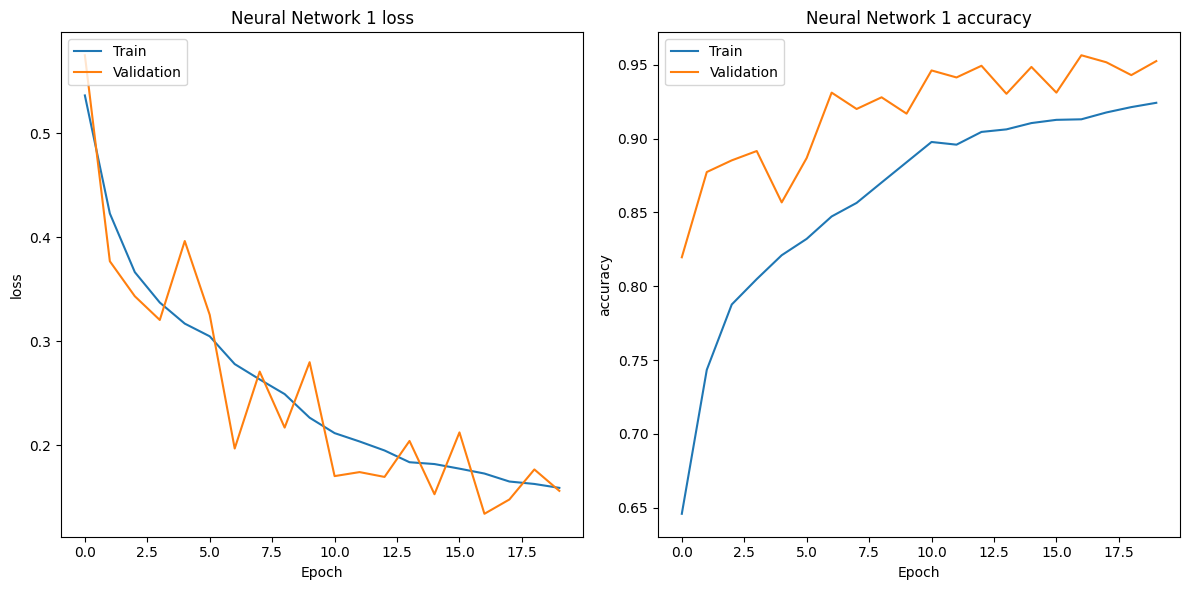

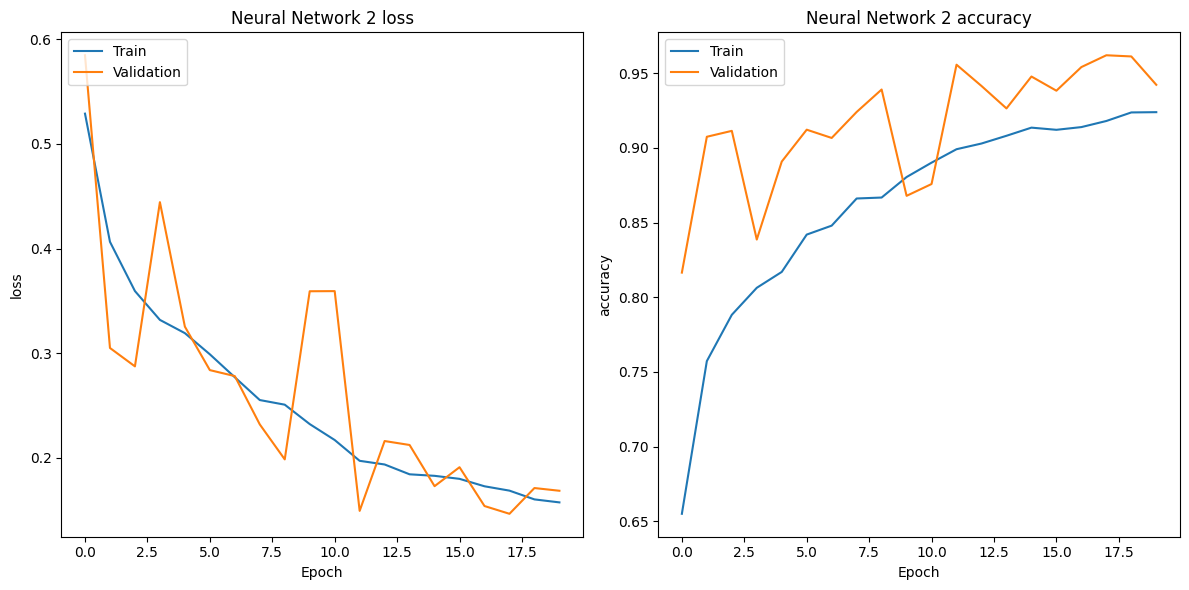

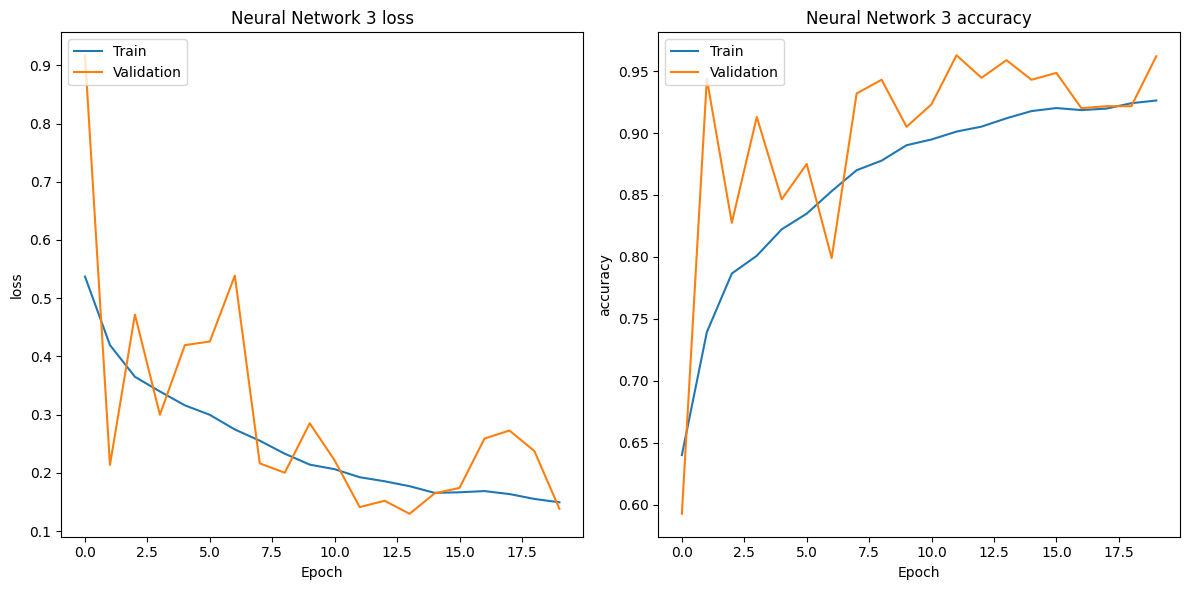

In [ ]:
for i, h in enumerate(histories):
  name = f"Neural Network {i+1}"
  plot_val_train(h.history, name)

#### NN export

In [ ]:
import os

if not os.path.exists('NNs'):
    os.makedirs('NNs')

for i, model in enumerate(neural_models):
    model.save(f'NNs/neural_network_model{i}.keras')


In [ ]:
!cp -r NNs/ $drive_dir

####NN import

In [ ]:
source_path = drive_dir + 'NNs/'
!cp -r $source_path NNs/

In [ ]:
neural_models = []

for i in range(0,3):
  source_path = f'new_NNs/new_NNs/neural_network_model{i}'
  model = load_model(source_path)
  neural_models.append(model)


In [ ]:
i = 0
neural_predictions = []
for nn in neural_models:
  name = f"Neural Network {i}"
  predict_nn(name, nn, X_test, neural_predictions)
  i+=1

Predicting with model Neural Network 0...
66/66 [==============================] - 0s 3ms/step
Predictions from model Neural Network 0 stored.


Predicting with model Neural Network 1...
66/66 [==============================] - 0s 3ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
66/66 [==============================] - 0s 3ms/step
Predictions from model Neural Network 2 stored.




In [ ]:
nn_metrics = []

for i, y_pred in enumerate(neural_predictions):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics, name)

nn_metrics = pd.DataFrame(nn_metrics)
nn_metrics.sort_values(by='Recall', ascending=False)

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
2  Neural Network 3     0.966      0.827   0.540     0.654    0.767
0  Neural Network 1     0.957      0.667   0.532     0.592    0.758
1  Neural Network 2     0.949      0.574   0.500     0.534    0.738

### Combined Performance

In [ ]:
combined_metrics = pd.concat([metrics, nn_metrics], ignore_index=True)
combined_metrics

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0         Decision Tree     0.972      0.944   0.548     0.694    0.913
1     Linear Regression     0.818      0.185   0.613     0.284    0.821
2  Gaussian Naive Bayes     0.890      0.284   0.573     0.380    0.850
3         Random forest     0.976      0.962   0.613     0.749    0.970
4     Linear Perceptron     0.939      0.433   0.105     0.169    0.548
5    K Nearest Neighbor     0.903      0.181   0.185     0.183    0.567
6              AdaBoost     0.973      0.876   0.629     0.732    0.957
7      Neural Network 1     0.957      0.667   0.532     0.592    0.758
8      Neural Network 2     0.949      0.574   0.500     0.534    0.738
9      Neural Network 3     0.966      0.827   0.540     0.654    0.767

In [ ]:
for i,model in enumerate(neural_models):
  models[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions):
  predictions[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection

In [ ]:
# Columns groups of interest
sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'Italian Residence_encoded', 'European Residence_encoded', 'Protected Category_encoded']
non_sensitive_features = data_set.columns.difference(sensitive_features)

# Tresholds
tolerance = 0.1
significance_level = 0.1

###Demographic Parity

In [ ]:
getFairnessTab(calculate_demographic_parity,
               models=models,
               sensitive_features = sensitive_features,
               predictions= predictions,
               index=list(models.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Age Range_encoded
Sparse contigency for Age Range_encoded


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Sex_encoded
female: 0.2988505747126437
male: 0.16816277678037103
Model unfair to: male


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Age Range_encoded
< 20 years: 0.0664819944598338
20 - 25 years: 0.12376237623762376
26 - 30 years: 0.1411764705882353
31 - 35 years: 0.2607260726072607
36 - 40 years: 0.358974358974359
40 - 45 years: 0.4
> 45 years: 0.46113989637305697
Model unfair to: < 20 years


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Italian Residence_encoded
no: 0.547945205479452
yes: 0.1824889326119036
Model unfair to: yes


=======

Sex_encoded Age Range_encoded Italian Residence_encoded  \
Decision Tree                        20 - 25 years                             
Linear Regression           male        < 20 years                       yes   
Gaussian Naive Bayes                 20 - 25 years                       yes   
Random forest                        20 - 25 years                             
Linear Perceptron                       < 20 years                             
K Nearest Neighbor                   40 - 45 years                             
AdaBoost                             20 - 25 years                             
Neural Network 1                     20 - 25 years                             
Neural Network 2                     20 - 25 years                             
Neural Network 3                     20 - 25 years                             

                     European Residence_encoded Protected Category_encoded  
Decision Tree                                                               
Linear Regression                      european                         no  
Gaussian Naive Bayes                   european                         no  
Random forest                                                               
Linear Perceptron                                                           
K Nearest Neighbor                                                          
AdaBoost                                                                    
Neural Network 1                                                            
Neural Network 2                                                            
Neural Network 3

### Equalized Odds

In [ ]:
getFairnessTab(calculate_equalized_odds,
               models=models,
               sensitive_features = sensitive_features,
               predictions= predictions,
               index=list(models.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Age Range_encoded
Maximum TPR difference: 0.4524 between group > 45 years and group 20 - 25 years
Model unfair to: 20 - 25 years
TPR and FPR for each group:
Group 26 - 30 years: TPR=0.4792, FPR=0.0012
Group < 20 years: TPR=0.6923, FPR=0.0000
Group 36 - 40 years: TPR=0.3846, FPR=0.0000
Group 20 - 25 years: TPR=0.3333, FPR=0.0050
Group 31 - 35 years: TPR=0.6818, FPR=0.0036
Group > 45 years: TPR=0.7857, FPR=0.0056
Group 40 - 45 years: TPR=0.3636, FPR=0.0000


===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Italian Residence_encoded
Maximum TPR difference: 0.5574 between group yes and group no
Model unfair to: no
TPR and FPR for each group:
Group yes: TPR=0.5574, FPR=0.0021
Group no: TPR=0.0000, FPR=0.0000


====

Sex_encoded Age Range_encoded Italian Residence_encoded  \
Decision Tree                        20 - 25 years                        no   
Linear Regression                       < 20 years                       yes   
Gaussian Naive Bayes                 20 - 25 years                       yes   
Random forest                        20 - 25 years                        no   
Linear Perceptron                       < 20 years                             
K Nearest Neighbor                      < 20 years                             
AdaBoost                             20 - 25 years                        no   
Neural Network 1                     36 - 40 years                             
Neural Network 2                     26 - 30 years                             
Neural Network 3                     20 - 25 years                             

                     European Residence_encoded Protected Category_encoded  
Decision Tree                      non-european                         no  
Linear Regression         non-european european                         no  
Gaussian Naive Bayes                   european                         no  
Random forest                      non-european                         no  
Linear Perceptron                                                           
K Nearest Neighbor                                                          
AdaBoost                           non-european                         no  
Neural Network 1                   non-european                         no  
Neural Network 2                   non-european                         no  
Neural Network 3                   non-european                         no

###Counterfactual Fairness

In [ ]:
getFairnessTab(
    calculate_counterfactual_fairness,
    models=models,
    sensitive_features= sensitive_features,
    predictions=predictions,
    index=list(models.keys()),
    X_test=X_test,
    significance_level=significance_level,
    tolerance=tolerance,
    verbose=True
)

Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: male 0.0000
Most discriminated group: male 0.0000
Most privileged group: male 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: 26 - 30 years 0.0000
Most discriminated group: 26 - 30 years 0.0000
Most privileged group: 26 - 30 years 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Counterfactual Fairness on Italian Residence_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: yes 0.0000
Most discriminated group: yes 0.0000
Most privileged group: yes 0.0000
Dir

Sex_encoded  \
Decision Tree                                                             
Linear Regression     (male, -0.030389363722697058, female, 0.141500...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1                                                          
Neural Network 2                                                          
Neural Network 3                                                          

                                                      Age Range_encoded  \
Decision Tree                                                             
Linear Regression     (< 20 years, -0.1225071225071225, > 45 years, ...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor    (20 - 25 years, 0.009021842355175688, > 45 yea...   
AdaBoost                                                                  
Neural Network 1      (< 20 years, -0.0023741690408357074, > 45 year...   
Neural Network 2      (< 20 years, 0.0033238366571699905, > 45 years...   
Neural Network 3      (20 - 25 years, 0.000949667616334283, > 45 yea...   

                                              Italian Residence_encoded  \
Decision Tree                                                             
Linear Regression     (yes, -0.007122507122507123, no, 0.24216524216...   
Gaussian Naive Bayes  (yes, -0.008072174738841406, no, 0.48338081671...   
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (yes, -0.001899335232668566, no, 0.10303893637...   
Neural Network 2                     (yes, 0.0, no, 0.1177587844254511)   
Neural Network 3                                                          

                                             European Residence_encoded  \
Decision Tree                                                             
Linear Regression     (european, -0.0023741690408357074, non-europea...   
Gaussian Naive Bayes  (european, 0.0, non-european, 0.7725546058879392)   
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (european, 0.0004748338081671415, non-european...   
Neural Network 2      (european, 0.001899335232668566, non-european,...   
Neural Network 3                                                          

                                             Protected Category_encoded  
Decision Tree                                                            
Linear Regression     (no, -0.000949667616334283, yes, 0.30389363722...  
Gaussian Naive Bayes  (no, -0.004748338081671415, yes, 0.88129154795...  
Random forest                                                            
Linear Perceptron                                                        
K Nearest Neighbor                                                       
AdaBoost                                                                 
Neural Network 1                                                         
Neural Network 2                                                         
Neural Network 3

##Explainers

###LIME (Local Interpretable Model-agnostic Explanations)
explanations for samples with index = 16,17,18, with the top 5 most relevant features.

LIME EXPLANATIONS FOR Decision Tree


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 500x300 with 0 Axes>

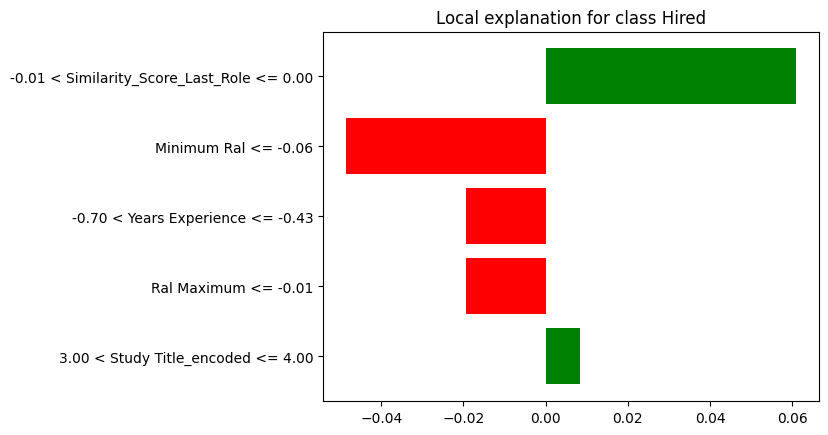

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


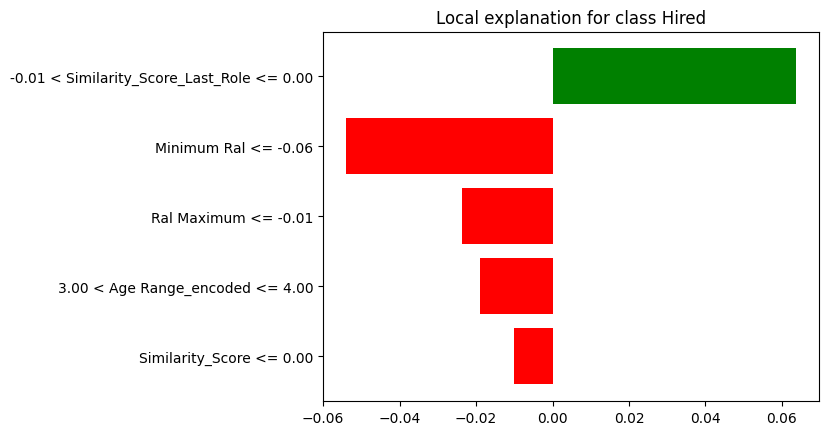

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


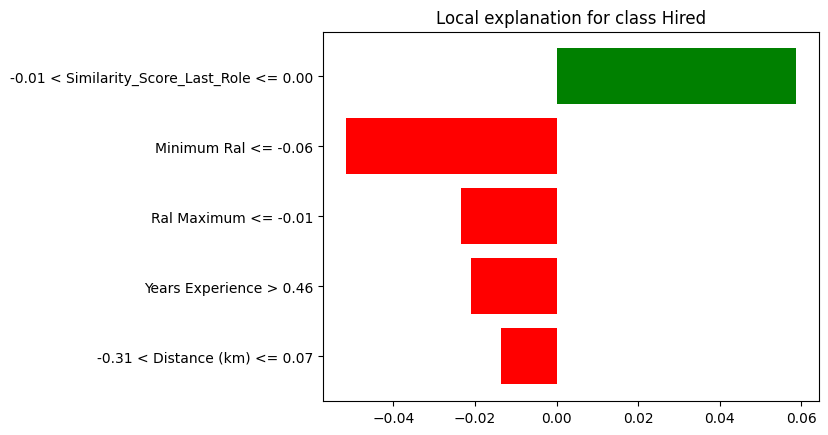

LIME EXPLANATIONS FOR Gaussian Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


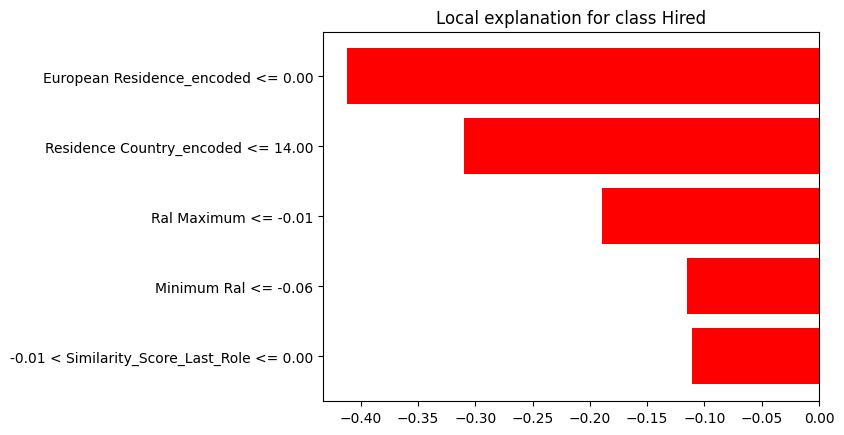

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


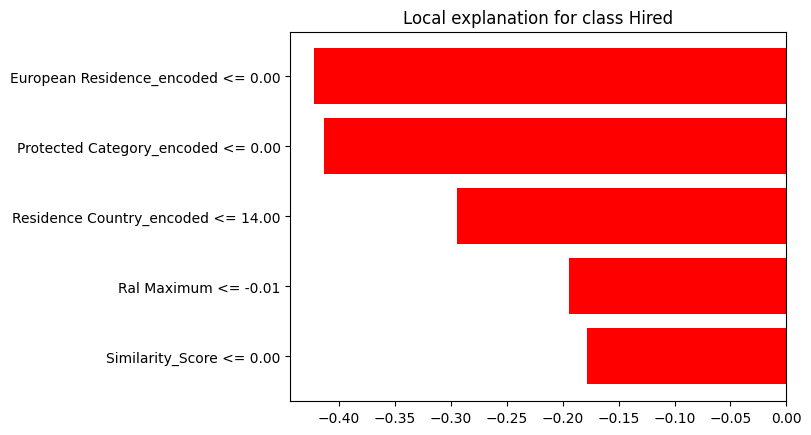

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


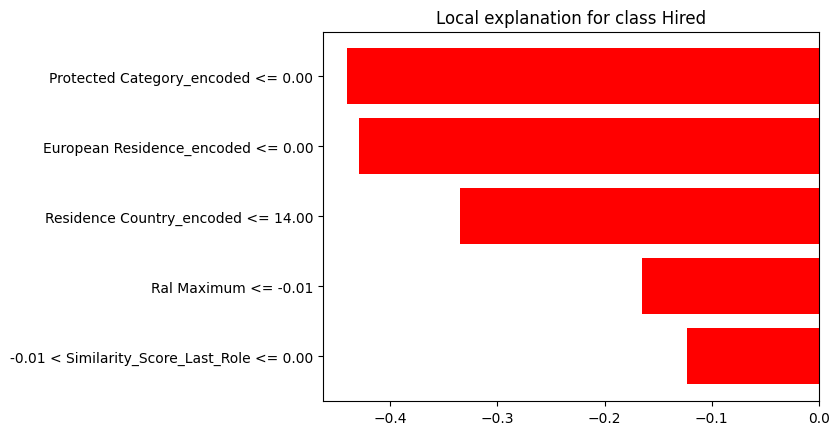

LIME EXPLANATIONS FOR Random forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


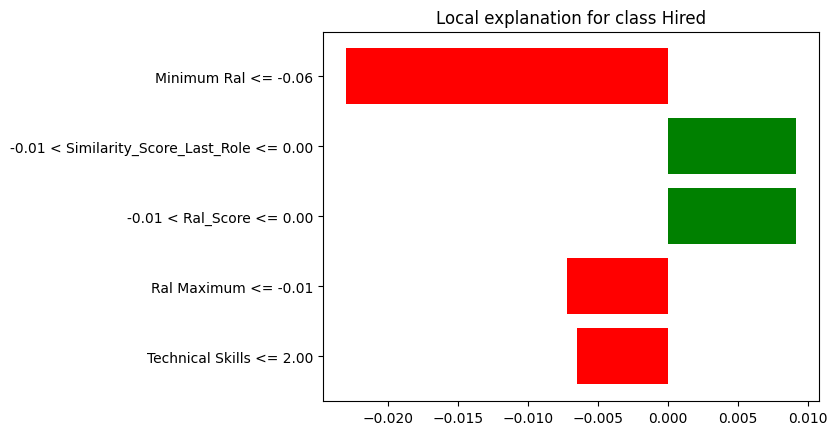

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


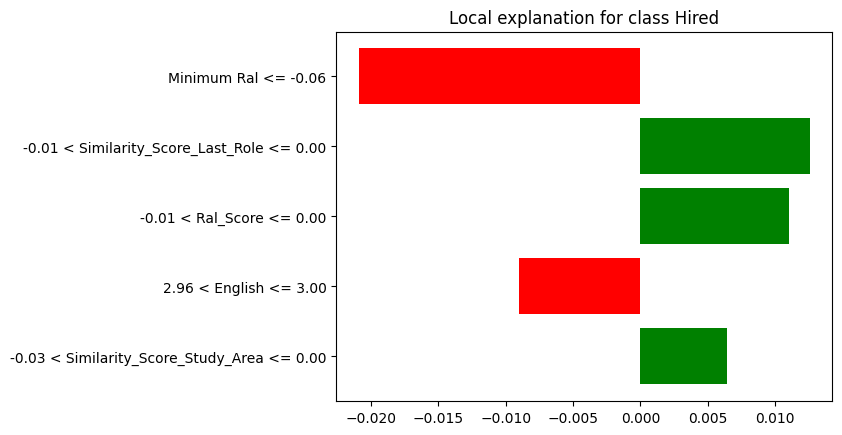

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


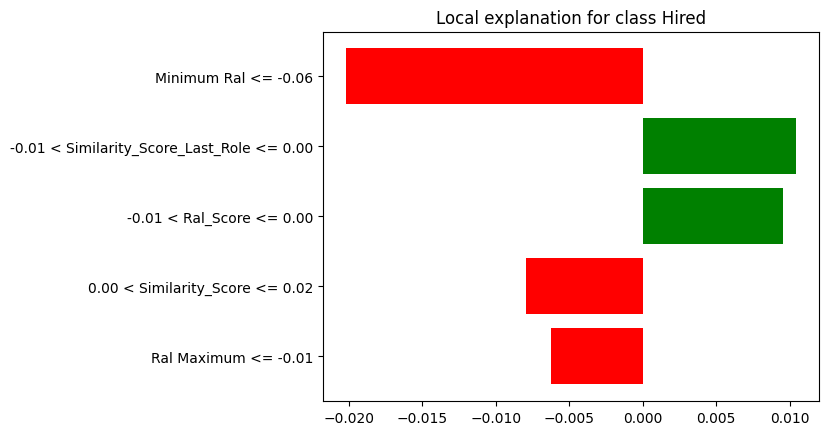

LIME EXPLANATIONS FOR K Nearest Neighbor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


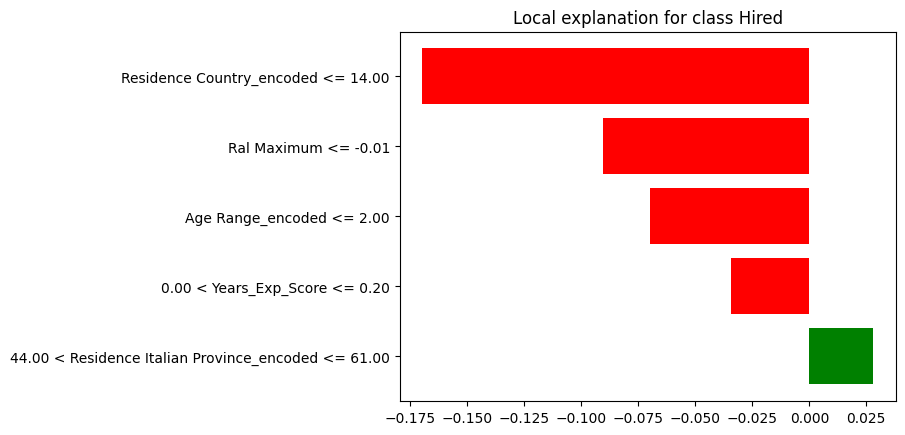

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


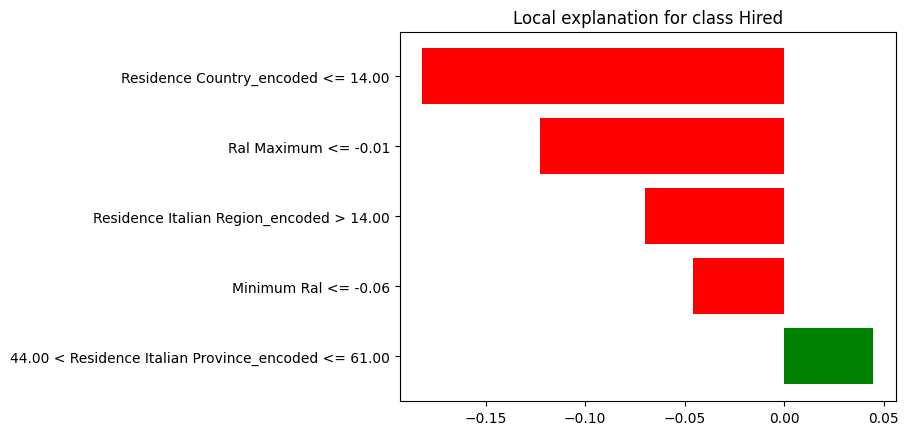

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


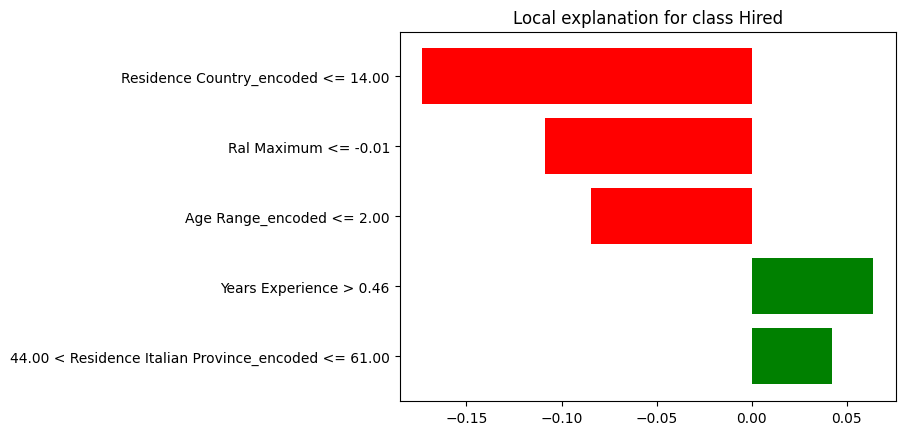

LIME EXPLANATIONS FOR AdaBoost


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


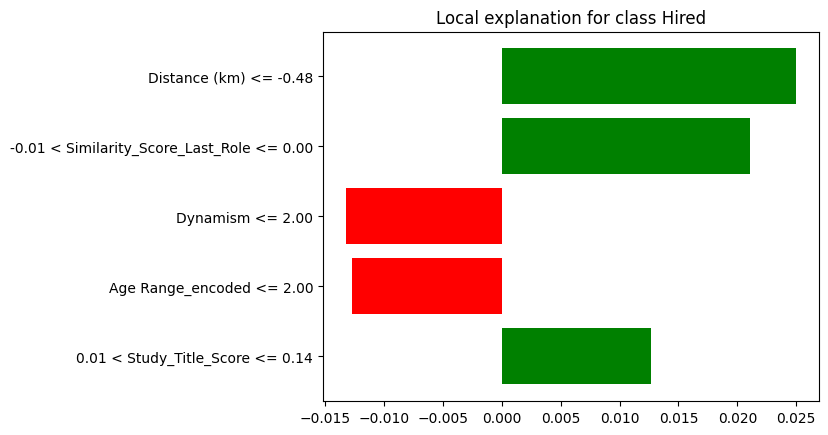

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


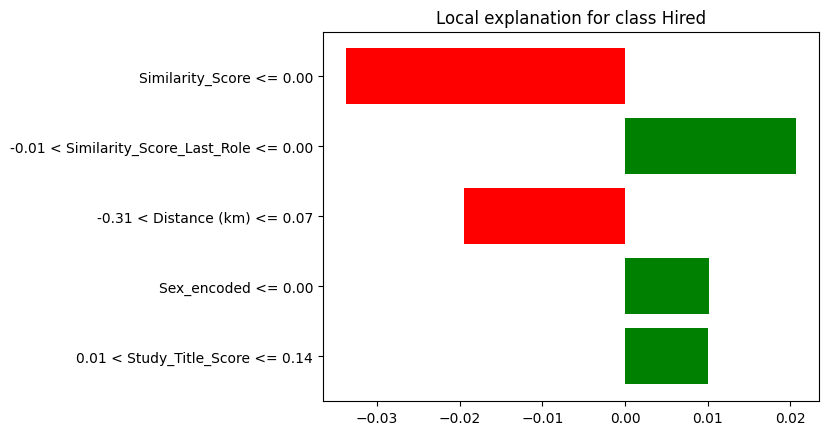

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


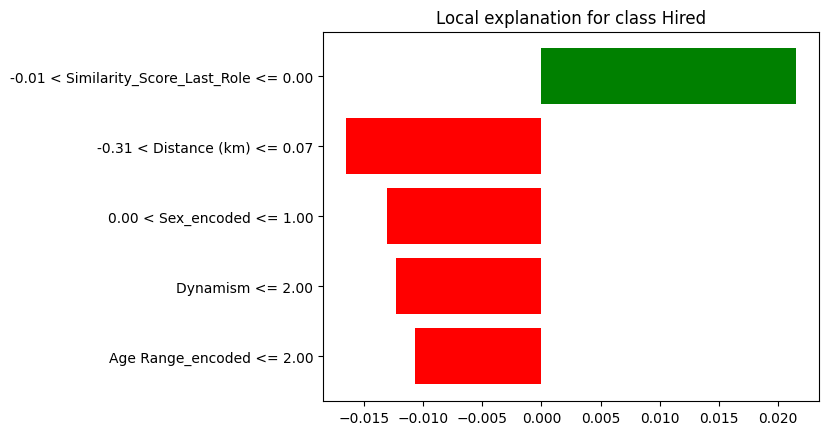

LIME EXPLANATIONS FOR Neural Network 1
157/157 [==============================] - 0s 2ms/step


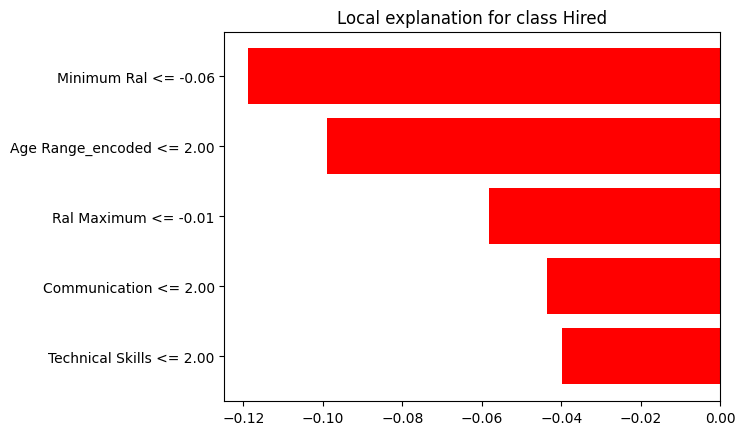

157/157 [==============================] - 0s 2ms/step


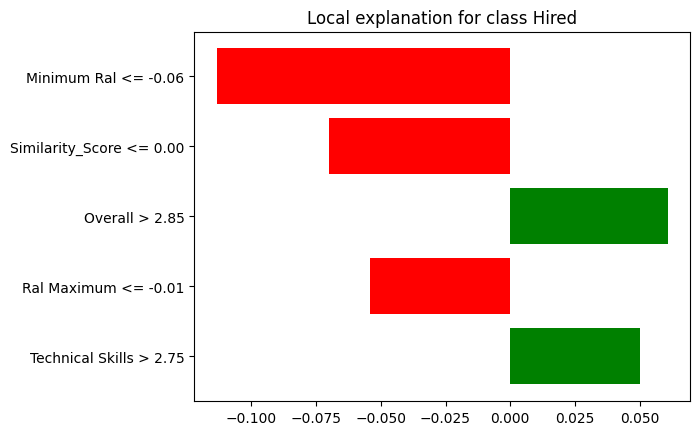

157/157 [==============================] - 0s 2ms/step


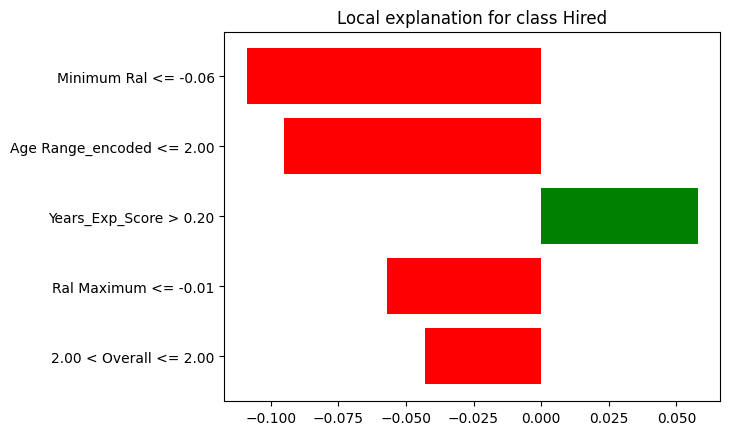

LIME EXPLANATIONS FOR Neural Network 2
157/157 [==============================] - 1s 3ms/step


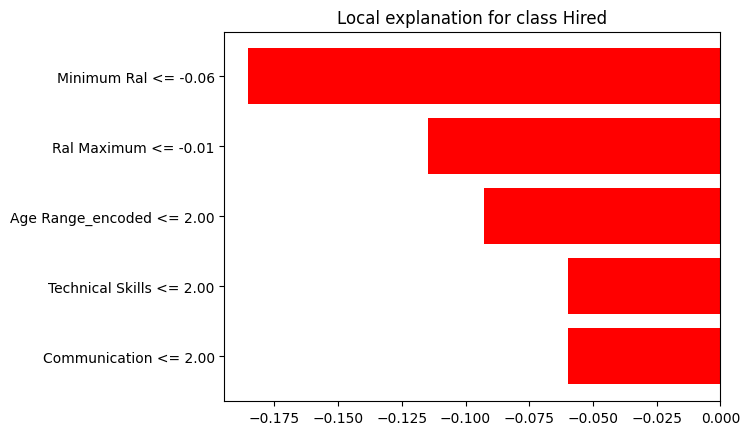

157/157 [==============================] - 0s 2ms/step


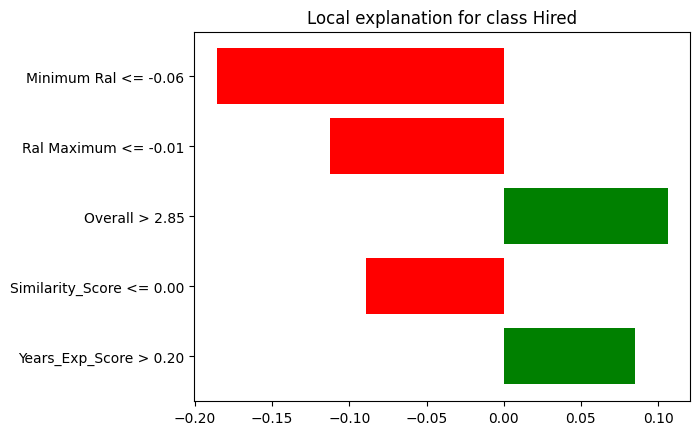

157/157 [==============================] - 0s 3ms/step


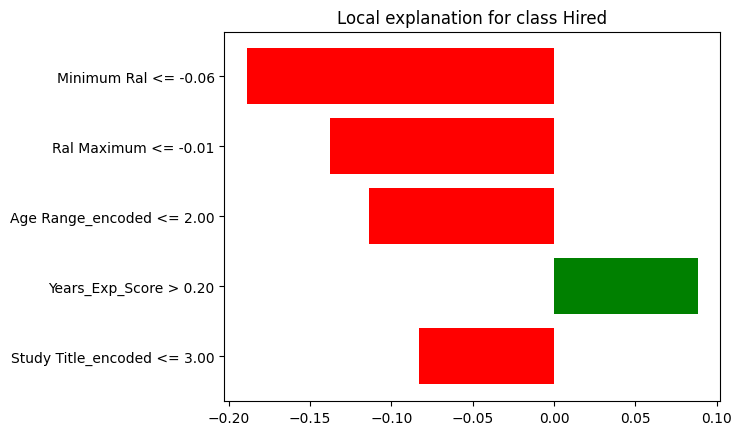

LIME EXPLANATIONS FOR Neural Network 3
157/157 [==============================] - 0s 2ms/step


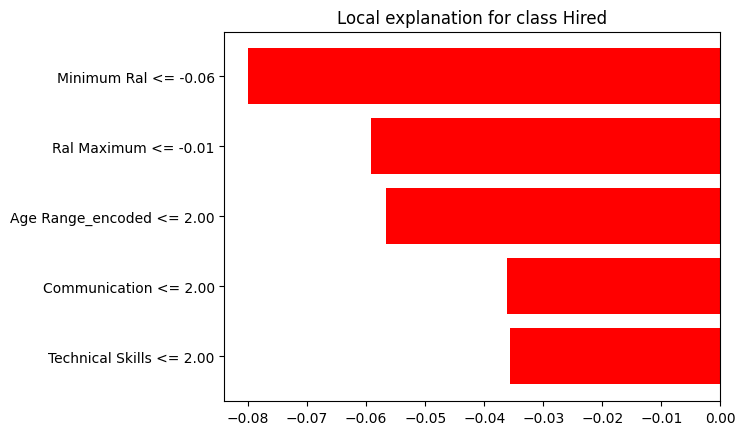

157/157 [==============================] - 0s 2ms/step


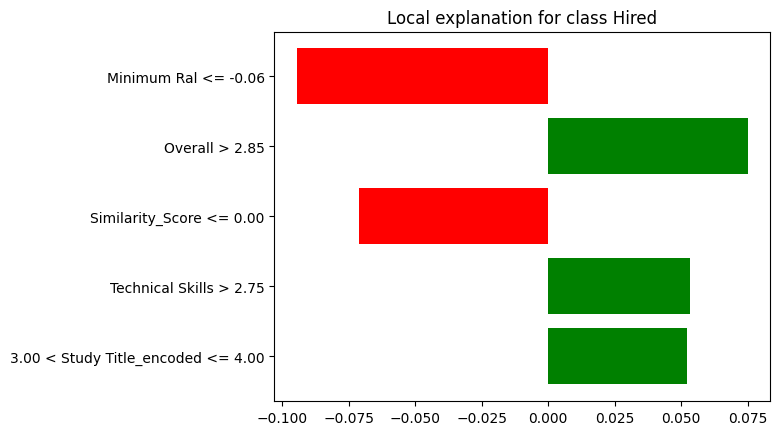

157/157 [==============================] - 0s 2ms/step


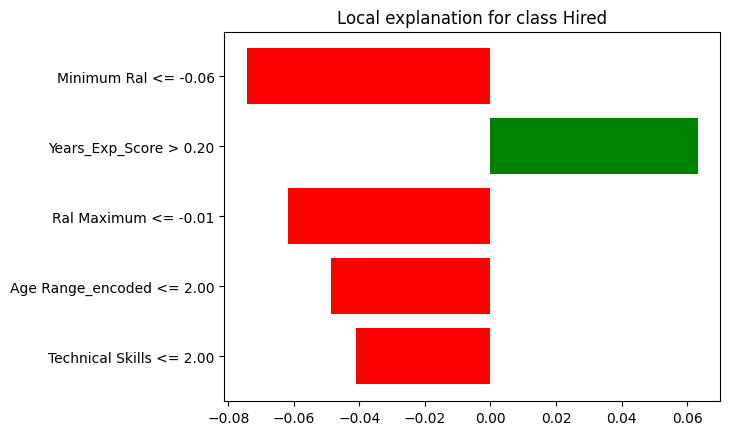

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode="classification",
    feature_names=X_train.columns.tolist(),
    class_names=['Not Hired', 'Hired'])
plt.figure(figsize=(5, 3))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        print(f"LIME EXPLANATIONS FOR {model_name}")
        for i in range(16,19):
            exp_dt = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=5) #Use model directly since we're iterating through values
            fig_dt = exp_dt.as_pyplot_figure()
            plt.show()

###Shap

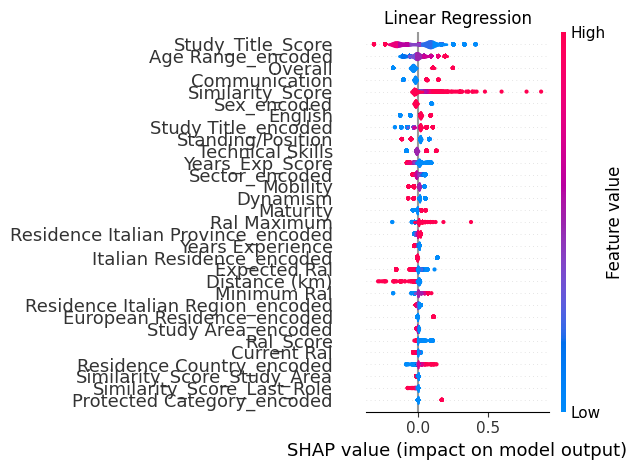

In [ ]:
tot_columns = list(X_test.columns)
summaryPlot(models['Linear Regression'], X_test, tot_columns, plot_type='violin', plot_name='Linear Regression')


1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

657/657 [==============================] - 1s 2ms/step
shap shape: (10, 31)


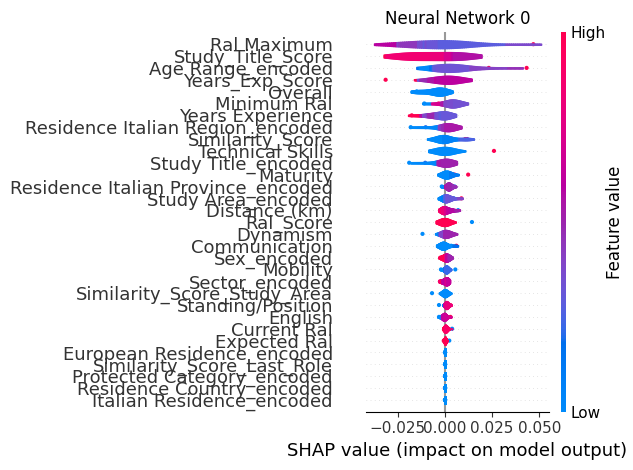

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

657/657 [==============================] - 1s 2ms/step
shap shape: (10, 31)


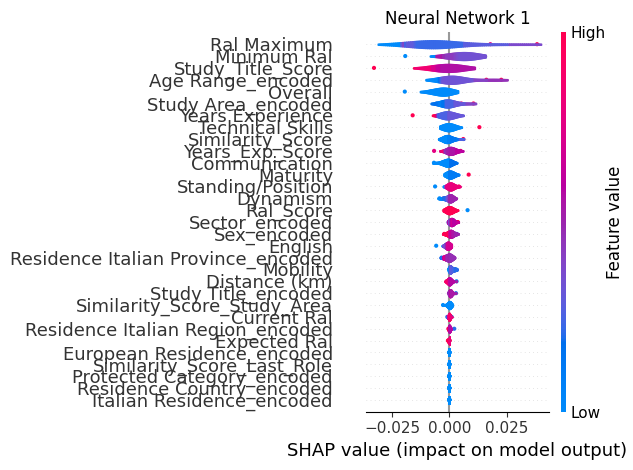

1/1 [==============================] - 0s 76ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

657/657 [==============================] - 1s 2ms/step
shap shape: (10, 31)


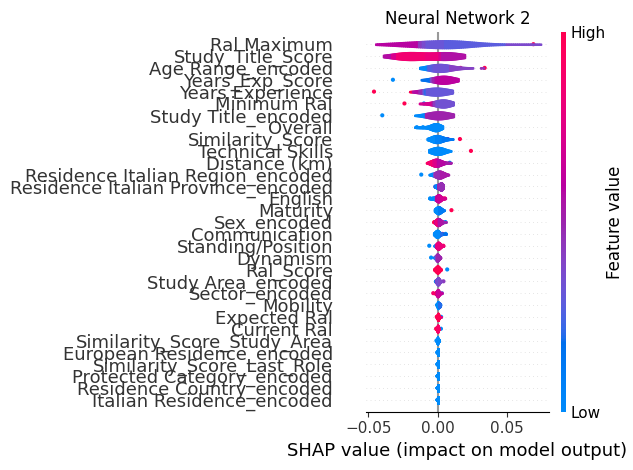

In [ ]:
tot_columns = list(X_test.columns)
for i,model in enumerate(neural_models):
    summaryPlot(model, X_test, tot_columns, plot_type='violin', plot_name=f'Neural Network {i}')

##Fairness improvement

###Reweighing

In [ ]:
X_train_models_reweighted, y_train_models_reweighted = reweight_dataset(X_train_models, y_train_models, sensitive_features)
X_train_reweighted, y_train_reweighted = reweight_dataset(X_train, y_train, sensitive_features)

In [ ]:
print("Distribution before reweighting:")
print(X_train[sensitive_features].value_counts())

print("\n\nDistribution after reweighting:")
print(X_train_reweighted[sensitive_features].value_counts())

Distribution before reweighting:
Sex_encoded  Age Range_encoded  Italian Residence_encoded  European Residence_encoded  Protected Category_encoded
1             2                 1                          0                           0                             2360
              3                 1                          0                           0                             1603
              0                 1                          0                           0                              780
0             2                 1                          0                           0                              739
1             4                 1                          0                           0                              670
                                                                                                                     ... 
              0                 1                          1                           1                                1

In [ ]:
metrics_rew = []
predictions_rew = {}
models_rew = {best_model_params['recall_macro'][m]['name'].rstrip(): best_model_params['recall_macro'][m]['estimator'] for m in best_model_params['recall_macro'].keys()}

for name, model in models_rew.items():
    fit_predict_model(name, model, X_train_models_reweighted, y_train_models_reweighted, X_test, y_test, metrics_rew, predictions_rew)

Fitting Decision Tree...
Fitting Linear Regression...
Fitting Gaussian Naive Bayes...
Fitting Random forest...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...


In [ ]:
metrics_rew = pd.DataFrame(metrics_rew)

In [ ]:
neural_models_rew = []
neural_predictions_rew = []
histories_rew = []

i = 0
for seed in range(85, 88):
    name = f'Neural Network {i+1}'
    i+=1
    fit_nn(name, seed, neural_models_rew, histories_rew, X_train_reweighted, y_train_reweighted, X_validation, y_validation, X_test, neural_predictions_rew, best_params_nn, early_stopping=early_stopping)

Fitting model Neural Network 1...
Epoch 1/20
344/344 [==============================] - 3s 5ms/step - loss: 0.1533 - accuracy: 0.6367 - val_loss: 1.5418 - val_accuracy: 0.2698
Epoch 2/20
344/344 [==============================] - 1s 4ms/step - loss: 0.1100 - accuracy: 0.7704 - val_loss: 0.6596 - val_accuracy: 0.7737
Epoch 3/20
344/344 [==============================] - 1s 4ms/step - loss: 0.0948 - accuracy: 0.8160 - val_loss: 0.6102 - val_accuracy: 0.8022
Epoch 4/20
344/344 [==============================] - 1s 4ms/step - loss: 0.0845 - accuracy: 0.8372 - val_loss: 0.5927 - val_accuracy: 0.7975
Epoch 5/20
344/344 [==============================] - 1s 4ms/step - loss: 0.0768 - accuracy: 0.8584 - val_loss: 0.3485 - val_accuracy: 0.8987
Epoch 6/20
344/344 [==============================] - 2s 5ms/step - loss: 0.0716 - accuracy: 0.8727 - val_loss: 0.2697 - val_accuracy: 0.9296
Epoch 7/20
344/344 [==============================] - 2s 6ms/step - loss: 0.0649 - accuracy: 0.8846 - val_loss: 0.

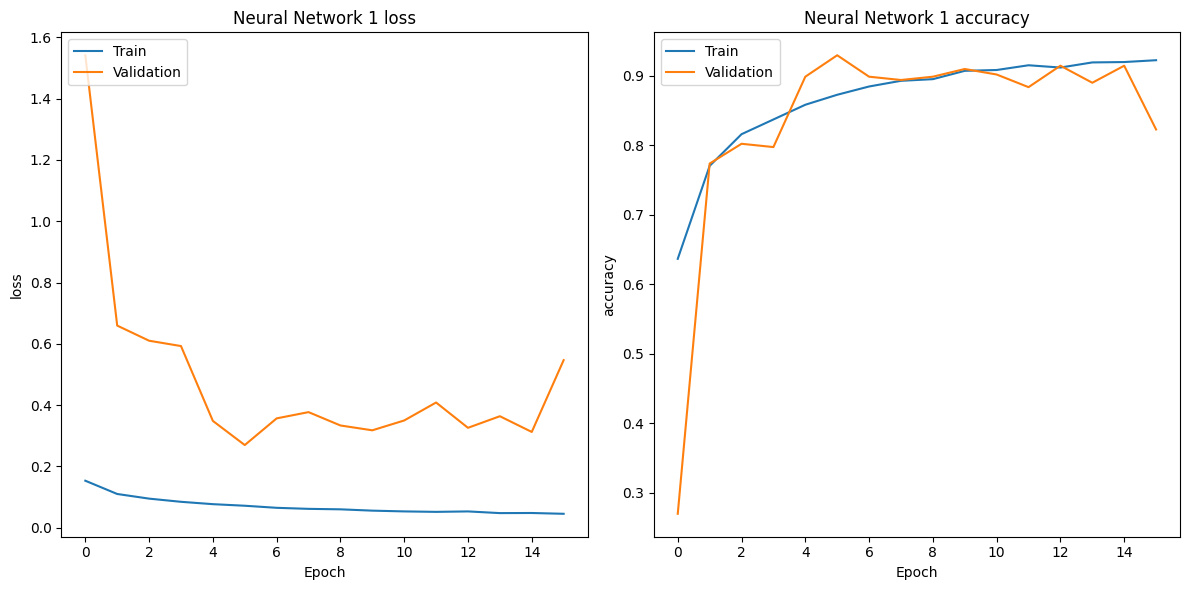

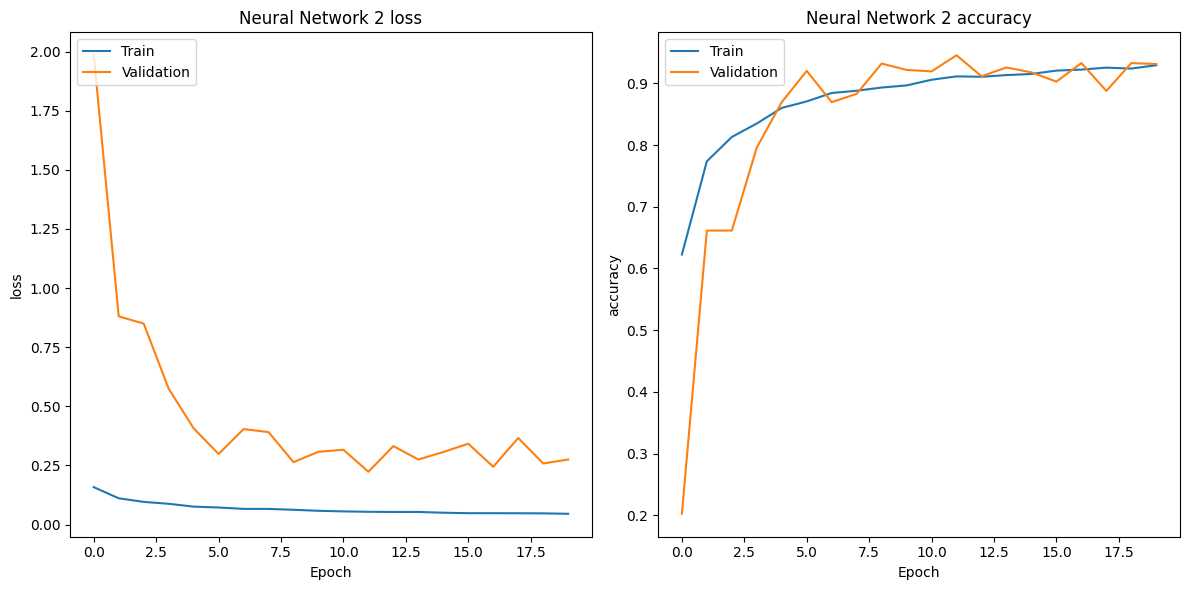

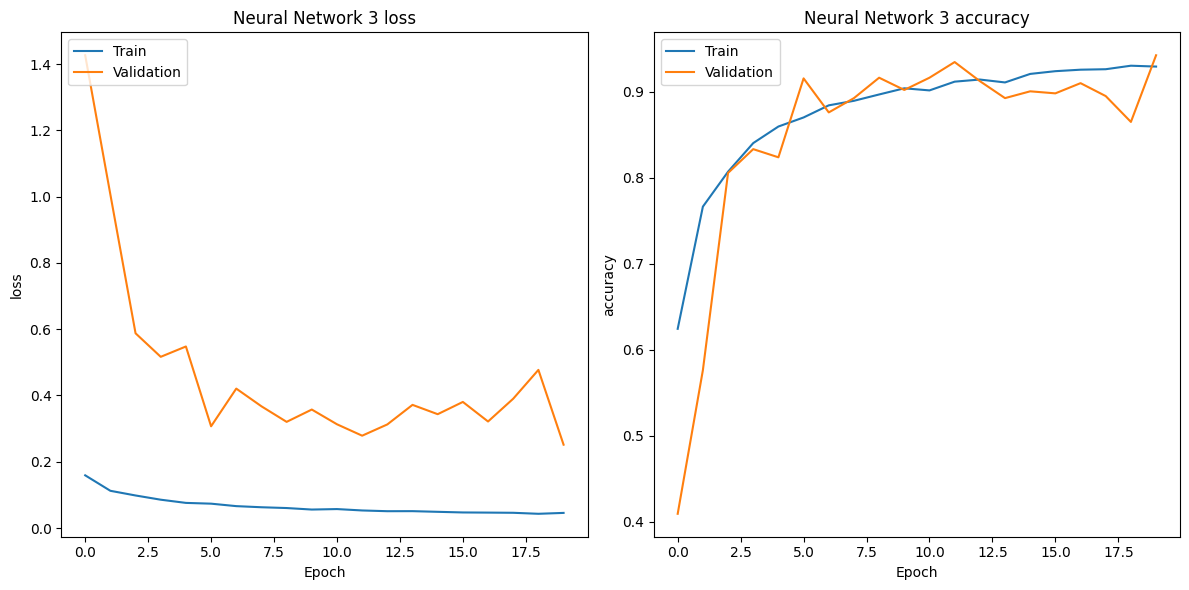

In [ ]:
for i, h in enumerate(histories_rew):
  name = f"Neural Network {i+1}"
  plot_val_train(h.history, name)

###NN reweighted export

In [ ]:
for i, model in enumerate(neural_models_rew):
  model.save(f'NNs_rew/neural_network_model_rew{i}')

In [ ]:
!cp -r NNs_rew/ $drive_dir

###NN reweighted import

In [ ]:
neural_models_rew = []

for i in range(0,3):
  model = load_model(f'{drive_dir}NNs_rew/neural_network_model_rew{i}')
  neural_models_rew.append(model)


###NN reweighted predict

In [ ]:
neural_predictions_rew = []
for i, model in enumerate(neural_models_rew):
  name = f"Neural Network {i+1}"
  predict_nn(name, model, X_test, neural_predictions_rew)

Predicting with model Neural Network 1...
66/66 [==============================] - 0s 2ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
66/66 [==============================] - 0s 2ms/step
Predictions from model Neural Network 2 stored.


Predicting with model Neural Network 3...
66/66 [==============================] - 0s 2ms/step
Predictions from model Neural Network 3 stored.




In [ ]:
nn_metrics_rew = []

for i, y_pred in enumerate(neural_predictions_rew):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics_rew, name)
nn_metrics_rew = pd.DataFrame(nn_metrics_rew)
nn_metrics_rew

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network 1     0.936      0.429   0.242     0.309    0.611
1  Neural Network 2     0.939      0.471   0.323     0.383    0.650
2  Neural Network 3     0.940      0.475   0.234     0.314    0.609

###Performance

In [ ]:
combined_metrics_rew = pd.concat([metrics_rew, nn_metrics_rew], ignore_index=True)
combined_metrics_rew.sort_values(by='Recall', ascending=False)

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
1     Linear Regression     0.333      0.079   0.968     0.146    0.795
2  Gaussian Naive Bayes     0.826      0.215   0.742     0.334    0.835
6              AdaBoost     0.957      0.654   0.565     0.606    0.934
0         Decision Tree     0.963      0.871   0.435     0.581    0.845
3         Random forest     0.964      0.962   0.403     0.568    0.938
4     Linear Perceptron     0.857      0.158   0.331     0.214    0.610
5    K Nearest Neighbor     0.697      0.069   0.331     0.114    0.525
8      Neural Network 2     0.939      0.471   0.323     0.383    0.650
7      Neural Network 1     0.936      0.429   0.242     0.309    0.611
9      Neural Network 3     0.940      0.475   0.234     0.314    0.609

In [ ]:
for i,model in enumerate(neural_models_rew):
  models_rew[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions_rew):
  predictions_rew[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection after REWEIGHING

###Demographic Parity

In [ ]:
getFairnessTab(calculate_demographic_parity,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Age Range_encoded
Sparse contigency for Age Range_encoded


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Sex_encoded
female: 0.8436781609195402
male: 0.6900059844404548
Model unfair to: male


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Age Range_encoded
< 20 years: 0.5678670360110804
20 - 25 years: 0.7227722772277227
26 - 30 years: 0.7729411764705882
31 - 35 years: 0.8283828382838284
36 - 40 years: 0.7350427350427351
40 - 45 years: 0.6625
> 45 years: 0.6321243523316062
Model unfair to: < 20 years


===============================UNFAIR!===============================
Model LinearRegression() unfair wrt Italian Residence_encoded
no: 0.5068493150684932
yes: 0.7294638465322184
Model unfair to: no


======

Sex_encoded Age Range_encoded Italian Residence_encoded  \
Decision Tree                        20 - 25 years                             
Linear Regression           male        < 20 years                        no   
Gaussian Naive Bayes                 20 - 25 years                        no   
Random forest                        20 - 25 years                             
Linear Perceptron                       < 20 years                             
K Nearest Neighbor                      < 20 years                        no   
AdaBoost                                < 20 years                             
Neural Network 1                        < 20 years                             
Neural Network 2                     20 - 25 years                             
Neural Network 3                     20 - 25 years                             

                     European Residence_encoded Protected Category_encoded  
Decision Tree                                                               
Linear Regression                  non-european                         no  
Gaussian Naive Bayes               non-european                             
Random forest                                                               
Linear Perceptron                                                       no  
K Nearest Neighbor                 non-european                        yes  
AdaBoost                                                                no  
Neural Network 1                                                            
Neural Network 2                                                        no  
Neural Network 3

### Equalized Odds

In [ ]:
getFairnessTab(calculate_equalized_odds,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Age Range_encoded
Maximum TPR difference: 0.3896 between group > 45 years and group 40 - 45 years
Model unfair to: 40 - 45 years
TPR and FPR for each group:
Group 26 - 30 years: TPR=0.4167, FPR=0.0000
Group < 20 years: TPR=0.5385, FPR=0.0057
Group 36 - 40 years: TPR=0.3846, FPR=0.0096
Group 20 - 25 years: TPR=0.3333, FPR=0.0000
Group 31 - 35 years: TPR=0.5000, FPR=0.0142
Group > 45 years: TPR=0.5714, FPR=0.0056
Group 40 - 45 years: TPR=0.1818, FPR=0.0000


===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Italian Residence_encoded
Maximum TPR difference: 0.4426 between group yes and group no
Model unfair to: no
TPR and FPR for each group:
Group yes: TPR=0.4426, FPR=0.0042
Group no: TPR=0.0000, FPR=0.0000


====

Sex_encoded Age Range_encoded Italian Residence_encoded  \
Decision Tree                        40 - 45 years                        no   
Linear Regression                       < 20 years                        no   
Gaussian Naive Bayes                 36 - 40 years                        no   
Random forest                        36 - 40 years                        no   
Linear Perceptron                    26 - 30 years                             
K Nearest Neighbor                   20 - 25 years                        no   
AdaBoost                             20 - 25 years                             
Neural Network 1                        < 20 years                        no   
Neural Network 2                     26 - 30 years                        no   
Neural Network 3                        < 20 years                       yes   

                     European Residence_encoded Protected Category_encoded  
Decision Tree                      non-european                         no  
Linear Regression                  non-european                         no  
Gaussian Naive Bayes               non-european                         no  
Random forest                      non-european                         no  
Linear Perceptron                  non-european                         no  
K Nearest Neighbor                 non-european                        yes  
AdaBoost                           non-european                         no  
Neural Network 1                   non-european                        yes  
Neural Network 2                   non-european                         no  
Neural Network 3                   non-european                        yes

###Counterfactual Fairness

In [ ]:
getFairnessTab(calculate_counterfactual_fairness,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: male 0.0000
Most discriminated group: male 0.0000
Most privileged group: male 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: 26 - 30 years 0.0000
Most discriminated group: 26 - 30 years 0.0000
Most privileged group: 26 - 30 years 0.0000
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42) unfair wrt Counterfactual Fairness on Italian Residence_encoded
Counterfactual consistency: 1.0000
Most inconsistent group: yes 0.0000
Most discriminated group: yes 0.0000
Most privileged group: yes 0.0000
Dir

Sex_encoded  \
Decision Tree                                                             
Linear Regression     (male, -0.03276353276353276, female, 0.1082621...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron                                                         
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1                                                          
Neural Network 2                                                          
Neural Network 3                                                          

                                                      Age Range_encoded  \
Decision Tree                                                             
Linear Regression     (< 20 years, -0.16286799620132952, > 45 years,...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron     (< 20 years, -0.07739791073124407, > 45 years,...   
K Nearest Neighbor    (< 20 years, -0.03751187084520418, > 45 years,...   
AdaBoost                                                                  
Neural Network 1      (< 20 years, -0.018043684710351376, > 45 years...   
Neural Network 2      (26 - 30 years, 0.0023741690408357074, > 45 ye...   
Neural Network 3      (20 - 25 years, -0.006647673314339981, > 45 ye...   

                                              Italian Residence_encoded  \
Decision Tree                                                             
Linear Regression     (yes, -0.0033238366571699905, no, 0.1301044634...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron     (yes, -0.0023741690408357074, no, 0.2046533713...   
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1                     (yes, 0.0, no, 0.3238366571699905)   
Neural Network 2                     (yes, 0.0, no, 0.4976258309591643)   
Neural Network 3      (yes, -0.0004748338081671415, no, 0.4230769230...   

                                             European Residence_encoded  \
Decision Tree                                                             
Linear Regression     (european, -0.0023741690408357074, non-europea...   
Gaussian Naive Bayes                                                      
Random forest                                                             
Linear Perceptron     (european, -0.0014245014245014246, non-europea...   
K Nearest Neighbor                                                        
AdaBoost                                                                  
Neural Network 1      (european, 0.0, non-european, 0.5156695156695157)   
Neural Network 2      (european, 0.0, non-european, 0.6961063627730294)   
Neural Network 3      (european, 0.0, non-european, 0.6068376068376068)   

                                             Protected Category_encoded  
Decision Tree                                                            
Linear Regression     (no, -0.001899335232668566, yes, 0.22507122507...  
Gaussian Naive Bayes  (no, -0.0004748338081671415, yes, 0.1391263057...  
Random forest                                                            
Linear Perceptron     (no, -0.001899335232668566, yes, 0.22744539411...  
K Nearest Neighbor                                                       
AdaBoost                                                                 
Neural Network 1                    (no, 0.0, yes, 0.16619183285849953)  
Neural Network 2      (no, -0.000949667616334283, yes, 0.25308641975...  
Neural Network 3

##Adversarial Debiasing

In [ ]:
epochs = 50
batch_size = 64
threshold = 0.5
logits = True

sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'Italian Residence_encoded', 'Protected Category_encoded']
sensitive_f = [X_train[col] for col in sensitive_features]

In [ ]:
def create_Main(neurons = 128, activation = 'relu',):
    model = Sequential([
        Input(shape=X_train.shape[1]),
        Dense(neurons, activation=activation),
        BatchNormalization(),
        Dropout(0.4),
        Dense(neurons, activation=activation),
        BatchNormalization(),
        Dropout(0.4),
        Dense(neurons//2, activation=activation),
        BatchNormalization(),
        Dense(1)
    ])
    return model

def create_adversary():
    adv = Sequential([
        Dense(128, input_dim=1, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    return adv

In [ ]:
def build_batched_data(X, y, sensitive_features, batch_size, names):
    Xb, yb, sens_f, X_adv_b = [], [], [], []
    for i in range(0, len(X), batch_size):
        Xb.append(X[i:i+batch_size])
        yb.append(y[i:i+batch_size])
    for i in range(len(sensitive_features)):
        temp1, temp2 = [], []
        X_adv = X.drop(names[i], axis=1)
        for j in range(0, len(X), batch_size):
            temp1.append(X_adv[j:j+batch_size])
            temp2.append(sensitive_features[i][j:j+batch_size])
        X_adv_b.append(temp1)
        sens_f.append(temp2)
    return Xb, yb, sens_f, X_adv_b

In [ ]:
def train_nn(main, adv, X, y, sens_f, X_adv, epochs, adv_n, print_step=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(len(X)):
            X_batch = tf.convert_to_tensor(X[i].values, dtype=tf.float32)
            y_batch = tf.convert_to_tensor(y[i].values, dtype=tf.float32)
            sens = tf.convert_to_tensor(sens_f[adv_n][i], dtype=tf.float32)

            with tf.GradientTape(persistent=True) as tape:
                main_preds = main(X_batch, training=True)
                loss_main = loss_fcn_main(y_batch, main_preds)
                adv_preds = adv[adv_n](main_preds, training=True)
                loss_adversary = loss_fcn_adv(sens, adv_preds)
                combined_loss = tf.subtract(loss_main, tf.multiply(0.25, loss_adversary))

            #update main model
            gradients_main = tape.gradient(combined_loss, main.trainable_variables)
            optimizerM.apply_gradients(zip(gradients_main, main.trainable_variables))

            #update adversary model
            gradients_adv = tape.gradient(loss_adversary, adv[adv_n].trainable_variables)
            optimizer_list[adv_n].apply_gradients(zip(gradients_adv, adv[adv_n].trainable_variables))

            del tape

            if i % print_step == 0:
                print(f"Batch {i}/{len(X)} - Main Loss: {loss_main.numpy()}, Adversary Loss: {loss_adversary.numpy()}, Combined Loss: {combined_loss.numpy()}")


In [ ]:
#loss functions
loss_fcn_main = BinaryCrossentropy(from_logits=logits)
loss_fcn_adv = BinaryCrossentropy(from_logits=logits)

#optimizers
#optimizerM = Adam(learning_rate=0.001)
optimizerM = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optimizer_list = [Adam(learning_rate=0.0005) for _ in range(4)]

In [ ]:
#main model
np.random.seed(85)
tf.random.set_seed(85)
main_model = create_Main(neurons = 256, activation='elu')
main_model.compile(optimizer=optimizerM, loss=loss_fcn_main, metrics=['accuracy'])

In [ ]:
#adversary models
adversary_models = [create_adversary() for _ in range(4)]
for adv in adversary_models:
    adv.compile(optimizer=Adam(learning_rate=0.0005), loss=loss_fcn_adv, metrics=['accuracy'])

In [ ]:
Xb, yb, sens_f, X_adv_b = build_batched_data(X_train, y_train, sensitive_f, batch_size, sensitive_features)

In [216]:
#initial adversary weights
weights = [adv.get_weights() for adv in adversary_models]

#training main model against each adversary
for j in range(4):
    print(f"\nTraining Main Model against Adversary {j}")
    train_nn(main_model, adversary_models, Xb, yb, sens_f, X_adv_b, epochs, adv_n=j, print_step=60)
    adversary_models[j].set_weights(weights[j])  #adversary weights reset


Training Main Model against Adversary 0
Epoch 1/50
Batch 0/172 - Main Loss: 0.9433409571647644, Adversary Loss: 0.9568621516227722, Combined Loss: 0.7041254043579102
Batch 60/172 - Main Loss: 0.7035890817642212, Adversary Loss: 0.6670407652854919, Combined Loss: 0.536828875541687
Batch 120/172 - Main Loss: 0.5339771509170532, Adversary Loss: 0.6337307691574097, Combined Loss: 0.3755444586277008
Epoch 2/50
Batch 0/172 - Main Loss: 0.46321913599967957, Adversary Loss: 0.6396408677101135, Combined Loss: 0.30330890417099
Batch 60/172 - Main Loss: 0.5765292644500732, Adversary Loss: 0.6506325006484985, Combined Loss: 0.4138711392879486
Batch 120/172 - Main Loss: 0.4579721689224243, Adversary Loss: 0.6021517515182495, Combined Loss: 0.30743423104286194
Epoch 3/50
Batch 0/172 - Main Loss: 0.4501982033252716, Adversary Loss: 0.6803504824638367, Combined Loss: 0.28011059761047363
Batch 60/172 - Main Loss: 0.47342079877853394, Adversary Loss: 0.6710860133171082, Combined Loss: 0.305649280548095

###Export main

In [217]:
main_model.save(f'Adversarial_Debiasing_mainNNs/neural_network_model_main')

!cp -r Adversarial_Debiasing_mainNNs/ $drive_dir

###Import main

In [ ]:
main_model = load_model(f'{drive_dir}Adversarial_Debiasing_mainNNs/neural_network_model_main')

###Main predictions

In [218]:
main_predictions = []

y_pred = (main_model.predict(X_test) > 0.5).astype("int32").squeeze()
main_predictions.append(y_pred)

66/66 [==============================] - 0s 2ms/step


In [219]:
nn_metrics_main = []

calc_nn_metrics(main_predictions[0], y_test, nn_metrics_main, 'Neural Network Main')

nn_metrics_main = pd.DataFrame(nn_metrics_main)
nn_metrics_main

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network Main      0.97      0.905    0.54     0.677    0.768

###Demographic Parity

In [220]:
models_main = {}
models_main[f"Neural Network Main"] = main_model
predictions_main = {}
predictions_main[f"Neural Network Main"] = main_predictions[0].flatten()

In [221]:
getFairnessTab(calculate_demographic_parity,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7ccc7c6d8c50> unfair wrt Age Range_encoded
Sparse contigency for Age Range_encoded




Sex_encoded Age Range_encoded Italian Residence_encoded  \
Neural Network Main                 20 - 25 years                             

                    Protected Category_encoded  
Neural Network Main

### Equalized Odds

In [222]:
getFairnessTab(calculate_equalized_odds,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7ccc7c6d8c50> unfair wrt Age Range_encoded
Maximum TPR difference: 0.5130 between group > 45 years and group 40 - 45 years
Model unfair to: 40 - 45 years
TPR and FPR for each group:
Group 26 - 30 years: TPR=0.5000, FPR=0.0025
Group < 20 years: TPR=0.5385, FPR=0.0029
Group 36 - 40 years: TPR=0.3846, FPR=0.0000
Group 20 - 25 years: TPR=0.3333, FPR=0.0050
Group 31 - 35 years: TPR=0.7273, FPR=0.0036
Group > 45 years: TPR=0.7857, FPR=0.0112
Group 40 - 45 years: TPR=0.2727, FPR=0.0000


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7ccc7c6d8c50> unfair wrt Protected Category_encoded
Maximum TPR difference: 0.4634 between group yes and group no
Model unfair to: no
TPR and FPR for each group:
Group no: TPR=0.5366, FPR=0.0036
Group yes: TPR=1.0000, FPR=0.0000




Sex_encoded Age Range_encoded Italian Residence_encoded  \
Neural Network Main                 40 - 45 years                             

                    Protected Category_encoded  
Neural Network Main                         no

###Counterfactual Fairness

In [223]:
getFairnessTab(calculate_counterfactual_fairness,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Model <keras.src.engine.sequential.Sequential object at 0x7ccc7c6d8c50> unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 0.9282
Most inconsistent group: female 0.0043
Most discriminated group: male -0.0014
Most privileged group: female 0.0043
Direction of bias (negative = worse, positive = better)


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7ccc7c6d8c50> unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 0.8165
Most inconsistent group: > 45 years 0.1244
Most discriminated group: < 20 years 0.0019
Most privileged group: > 45 years 0.1244
Direction of bias (negative = worse, positive = better)


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7ccc7c6d8c50> unfair wrt Counterfactual Fairness on Italian Residence_encoded
Counterfactual consistency: 0.8903
Most incon

Sex_encoded  \
Neural Network Main               

                                                     Age Range_encoded  \
Neural Network Main  (< 20 years, 0.001899335232668566, > 45 years,...   

                                             Italian Residence_encoded  \
Neural Network Main  (yes, 0.0023741690408357074, no, 0.04510921177...   

                    Protected Category_encoded  
Neural Network Main

##Explainers

1/1 [==============================] - 0s 140ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

653/653 [==============================] - 1s 1ms/step
shap shape: (10, 30)


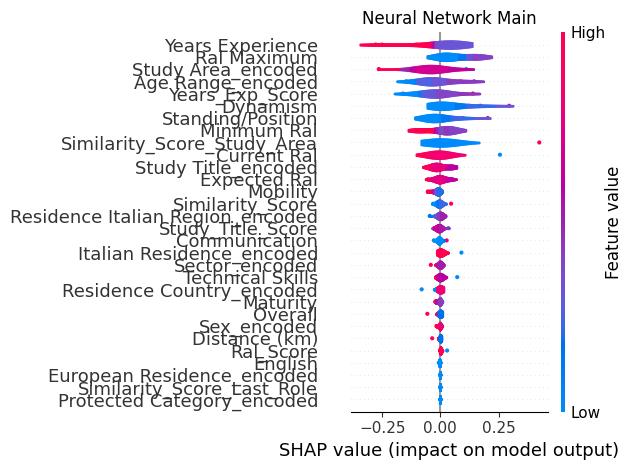

In [ ]:
tot_columns = list(X_test.columns)
summaryPlot(main_model, X_test, tot_columns, plot_type='violin', plot_name=f'Neural Network Main')